# Import

In [1]:
import numpy as np
import pandas as pd
import tqdm
import argparse
import os
import shutil
import pickle
from ai_clinician.modeling.models.komorowski_model import *
from ai_clinician.modeling.models.common import *
from ai_clinician.modeling.columns import C_OUTCOME
from ai_clinician.preprocessing.utils import load_csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tqdm.tqdm.pandas()

In [2]:
main_path = '/home/lkapral/RRT_mimic_iv' 

In [3]:
fixed_num_features = 40 # This is the number of features which should be included in the end, calculated with "Clustering_Experiment.ipynb"
n_actions = 2

In [4]:
def create_args():
    parser = argparse.ArgumentParser(description=(
        'Evaluates an AI Clinician model on the MIMIC-IV test set.'
    ))
    parser.add_argument('data', type=str,
                        help='Model data directory (should contain train and test directories)')
    parser.add_argument('model', type=str,
                        help='Path to pickle file containing the model')
    parser.add_argument('--out', dest='out_path', type=str, default=None,
                        help='Path to pickle file at which to write out results (optional)')
    parser.add_argument('--gamma', dest='gamma', type=float, default=0.99,
                        help='Decay for reward values (default 0.99)')
    parser.add_argument('--soften-factor', dest='soften_factor', type=float, default=0.05,
                        help='Amount by which to soften factors (random actions will be chosen this proportion of the time)')
    parser.add_argument('--num-iter-ql', dest='num_iter_ql', type=int, default=6,
                        help='Number of bootstrappings to use for TD learning (physician policy)')
    parser.add_argument('--num-iter-wis', dest='num_iter_wis', type=int, default=1000,
                        help='Number of bootstrappings to use for WIS estimation (AI policy)')
    
    # Simulate command-line arguments
    simulated_input = [
        main_path+'/data/model',
        main_path+'/data/model/models_penal/0.22/model_params_40/top5/top5_model_2.pkl',
        '--gamma', '0.99',
        '--soften-factor', '0.01',
        '--num-iter-ql', '6',
        '--num-iter-wis', '500'
    ]
    
    return parser.parse_args(simulated_input)

# Use the args
args = create_args()
output_dir = main_path+'/data/model'
data_dir = args.data
model = AIClinicianModel.load(args.model)
assert model.metadata is not None, "Model missing metadata needed to generate actions"


Loaded_feature_weights [0.3943926  0.27756421 0.24343556 0.23991552 0.21412183 0.18868424
 0.1835645  0.18020105 0.17104588 0.1679103  0.16144925 0.15938839
 0.15371076 0.1529229  0.15073967 0.1478161  0.1438637  0.1434054
 0.1417021  0.14009531 0.11779231 0.11505856 0.11428096 0.11317841
 0.11120712 0.11085235 0.1085031  0.10663935 0.10595175 0.10565174
 0.10279287 0.10241132 0.10177746 0.10109605 0.09985348 0.09779006
 0.09721884 0.09706016 0.09613519 0.09512068 1.        ]


In [5]:
feature_importance = pd.read_csv(main_path+'/data/model/combined_feature_importances.csv')

weights = feature_importance.head(fixed_num_features)['Combined_Average'].values
feature_weights = weights / np.linalg.norm(weights)
reduced_features = feature_importance.head(fixed_num_features)['Feature'].tolist()

In [6]:
MIMICraw = load_csv(os.path.join(data_dir, "test", "MIMICraw.csv"))

MIMICzs = pd.read_csv(os.path.join(data_dir, "test", "MIMICzs.csv"))
metadata = load_csv(os.path.join(data_dir, "test", "metadata.csv"))
unique_icu_stays = metadata[C_ICUSTAYID].unique()

In [7]:
print("Create actions") #If there is an RRT related column -> RRT = 1

rrt_cols = [
    'Ultrafiltrate_Output',
    'Blood_Flow',
    'Hourly_Patient_Fluid_Removal',
    'Dialysate_Rate',
    'Hemodialysis_Output', 
    'Citrate',
    'Prefilter_Replacement_Rate',
    'Postfilter_Replacement_Rate'
]
# 
rrt_actions = (~MIMICraw[rrt_cols].isna() & (MIMICraw[rrt_cols] != 0)).any(axis=1)
MIMICraw['action'] = rrt_actions.astype(int)

np.seterr(divide='ignore', invalid='ignore')

Create actions


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [8]:
MIMICraw['RRT'] = MIMICraw['action']
MIMICzs['RRT'] = MIMICraw['action']

In [9]:
actions_RRT = MIMICraw['action'].values

In [10]:
n_cluster_states = model.n_cluster_states

In [11]:
MIMICzs = MIMICzs[reduced_features+ ['RRT']]
MIMICraw = MIMICraw[reduced_features + ['RRT']]
feature_weights = np.append(feature_weights,1)

# Policy Evaluation

In [12]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

In [13]:
blocs = metadata[C_BLOC].values
stay_ids = metadata[C_ICUSTAYID].values
outcomes = metadata[C_OUTCOME].values 

print("Evaluating on MIMIC test set...")
states = model.compute_states(MIMICzs.values)

records = build_complete_record_sequences(
    metadata,
    states,
    actions_RRT,
    model.absorbing_states,
    model.rewards
)

# Evaluate the physician's policy using Temporal Difference (TD) Learning
test_bootql = evaluate_physician_policy_td(
    records,
    model.physician_policy,
    args.gamma,
    args.num_iter_ql,
    model.n_cluster_states
)
physpol_test, transitionr_test, R_test = compute_physician_policy(
    records,
    model.n_states,
    model.n_actions,
    model.absorbing_states,
    reward_val=model.reward_val,
    transition_threshold=model.transition_threshold,
)
# Compute probabilities for policy evaluation
phys_probs = model.compute_physician_probabilities(states=states, actions=actions_RRT)
model_probs = model.compute_probabilities(states=states, actions=actions_RRT)

Evaluating on MIMIC test set...


TD evaluation: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.33s/it]


Zeroing out 445/1004 transitions
Create reward matrix R(S, A)


In [14]:
# Evaluate the AI policy using Weighted Importance Sampling (WIS)
test_bootwis, _,  estimates = evaluate_policy_wis(
    metadata,
    phys_probs,
    model_probs,
    model.rewards,
    args.gamma,
    args.num_iter_wis,
    save_roh=True
)

# Prepare model statistics
model_stats = {}
model_stats['test_bootql_0.95'] = np.quantile(test_bootql, 0.95)   # Physicians' 95% Upper Bound
model_stats['test_bootql_mean'] = np.nanmean(test_bootql)
model_stats['test_bootql_0.99'] = np.quantile(test_bootql, 0.99)
model_stats['test_bootwis_mean'] = np.nanmean(test_bootwis)    
model_stats['test_bootwis_0.01'] = np.quantile(test_bootwis, 0.01)  
wis_95lb = np.quantile(test_bootwis, 0.05)  # AI's 95% Lower Bound
model_stats['test_bootwis_0.05'] = wis_95lb
model_stats['test_bootwis_0.95'] = np.quantile(test_bootwis, 0.95)

# Display the results with explanations
print("\nEvaluation Results:")

print("\n1. Physician's Policy Evaluation (Temporal Difference Learning):")
print(f"- Mean Value of Physician's Policy: {model_stats['test_bootql_mean']:.4f}")
print(f"- 95% Upper Bound of Physician's Policy Value: {model_stats['test_bootql_0.95']:.4f}")
print(f"- 99% Upper Bound of Physician's Policy Value: {model_stats['test_bootql_0.99']:.4f}")

print("\n2. AI Policy Evaluation (Weighted Importance Sampling):")
print(f"- Mean Value of AI Policy: {model_stats['test_bootwis_mean']:.4f}")
print(f"- 5% Lower Bound of AI Policy Value: {model_stats['test_bootwis_0.05']:.4f}")
print(f"- 1% Lower Bound of AI Policy Value: {model_stats['test_bootwis_0.01']:.4f}")
print(f"- 95% Upper Bound of AI Policy Value: {model_stats['test_bootwis_0.95']:.4f}")

# Interpret the results in clinical terms
print("\nInterpretation:")
print("The policy values represent the expected future rewards (e.g., survival) associated with each policy.")
print("A higher policy value suggests better expected patient outcomes.")
print("The AI policy's mean value and lower bounds indicate it may outperform the physician's policy.")
print("However, confidence intervals overlap, and clinical significance should be carefully evaluated.")

WIS estimation: 100%|█████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.63it/s]


Evaluation Results:

1. Physician's Policy Evaluation (Temporal Difference Learning):
- Mean Value of Physician's Policy: 59.3946
- 95% Upper Bound of Physician's Policy Value: 62.5612
- 99% Upper Bound of Physician's Policy Value: 63.0187

2. AI Policy Evaluation (Weighted Importance Sampling):
- Mean Value of AI Policy: 93.0882
- 5% Lower Bound of AI Policy Value: 86.2677
- 1% Lower Bound of AI Policy Value: 69.1860
- 95% Upper Bound of AI Policy Value: 94.1477

Interpretation:
The policy values represent the expected future rewards (e.g., survival) associated with each policy.
A higher policy value suggests better expected patient outcomes.
The AI policy's mean value and lower bounds indicate it may outperform the physician's policy.
However, confidence intervals overlap, and clinical significance should be carefully evaluated.


# Action distribution

In [16]:
records.loc[records['action']==-1,'action'] = 0
actions = records['action']

if 'MIMICraw' not in globals():
    raise NameError("MIMICraw DataFrame is not defined. Please load it before merging.")

MIMICraw[records.columns] = records
MIMICzs[records.columns] = records

full_data_raw = MIMICraw.copy()
full_data_zs = MIMICzs.copy()

MIMICraw.drop(columns=records.columns, inplace=True)
MIMICzs.drop(columns=records.columns, inplace=True)

RRT_counts = full_data_raw.groupby('state')['RRT'].value_counts().unstack(fill_value=0).reset_index(drop=True).reset_index(drop=True)

In [17]:
action_counts = np.bincount(actions, minlength=2)
action_percentages = action_counts / len(actions)

optimal_actions = model.Q.argmax(axis=1)  # AI's recommended actions
optimal_action_counts = np.bincount(optimal_actions, minlength=2)
optimal_action_percentages = optimal_action_counts / len(optimal_actions)

mortality_rates = []
for action_value in [0, 1]:
    indices = np.where(actions == action_value)
    mortality = outcomes[indices]
    mortality_rate = np.mean(mortality)
    mortality_rates.append(mortality_rate)

In [18]:
import matplotlib.font_manager as font_manager

font_dir = main_path
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

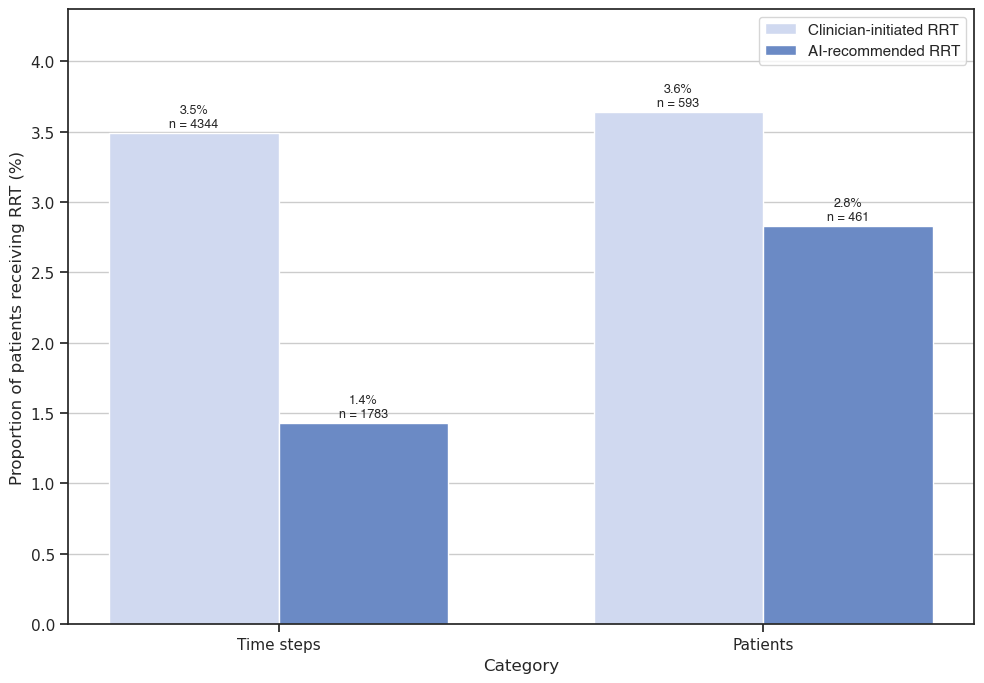

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

sns.set(style="ticks", palette="pastel")

state_to_optimal_action = {state: action for state, action in enumerate(optimal_actions)}

records['ai_action'] = records['state'].map(state_to_optimal_action)


if records['ai_action'].isnull().any():
    missing_states = records[records['ai_action'].isnull()]['state'].unique()
    raise ValueError(f"Missing optimal actions for states: {missing_states}")

records['action'] = records['action'].replace(-1, 0)


patient_actions = records.groupby('icustayid').agg({
    'action': lambda x: int((x == 1).any()),        
    'ai_action': lambda x: int((x == 1).any()),     
    'outcome': 'first'                              
}).reset_index()

patient_actions.rename(columns={'action': 'clinician_rrt', 'ai_action': 'ai_rrt'}, inplace=True)

clinician_time_steps_rrt = (records['action'] == 1).sum()
total_time_steps = len(records)
clinician_time_steps_proportion = clinician_time_steps_rrt / total_time_steps*100

ai_time_steps_rrt = (records['ai_action'] == 1).sum()
ai_time_steps_proportion = ai_time_steps_rrt / total_time_steps*100

clinician_patient_rrt = patient_actions['clinician_rrt'].sum()
total_patients = len(patient_actions)
clinician_patient_proportion = clinician_patient_rrt / total_patients*100

ai_patient_rrt = patient_actions['ai_rrt'].sum()
ai_patient_proportion = ai_patient_rrt / total_patients*100

plot_data = {
    'Time steps': {
        'Clinician-initiated RRT': (clinician_time_steps_proportion, clinician_time_steps_rrt),
        'AI-recommended RRT': (ai_time_steps_proportion, ai_time_steps_rrt)
    },
    'Patients': {
        'Clinician-initiated RRT': (clinician_patient_proportion, clinician_patient_rrt),
        'AI-recommended RRT': (ai_patient_proportion, ai_patient_rrt)
    }
}

categories = list(plot_data.keys())
methods = ['Clinician-initiated RRT', 'AI-recommended RRT']

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams['font.family'] = 'Helvetica'

bar_width = 0.35
index = np.arange(len(categories))  # [0, 1]

# Extract data for plotting
clinician_values = [plot_data[cat]['Clinician-initiated RRT'][0] for cat in categories]
ai_values = [plot_data[cat]['AI-recommended RRT'][0] for cat in categories]

clinician_counts = [plot_data[cat]['Clinician-initiated RRT'][1] for cat in categories]
ai_counts = [plot_data[cat]['AI-recommended RRT'][1] for cat in categories]

colors = {    
    'Clinician-initiated RRT': '#d0d9f0',          # Keeps the calming and professional feel
    'AI-recommended RRT': '#6b8ac5'                     # Replaces 'salmon' with a trustworthy color
}

bars1 = ax.bar(index - bar_width/2, clinician_values, bar_width, label='Clinician-initiated RRT', color=colors['Clinician-initiated RRT'])
bars2 = ax.bar(index + bar_width/2, ai_values, bar_width, label='AI-recommended RRT', color=colors['AI-recommended RRT'])

ax.set_xlabel('Category')
ax.set_ylabel('Proportion of patients receiving RRT (%)')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend()


def add_percentage_count_labels(bars, counts):
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{round(height,1)}%\nn = {count}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

add_percentage_count_labels(bars1, clinician_counts)
add_percentage_count_labels(bars2, ai_counts)

ax.yaxis.grid(True)
max_bar = max(max(clinician_values, ai_values))
y_max = max_bar * 1.2 if max_bar * 1.2 < 100 else 100

ax.set_ylim(0, y_max)

plt.tight_layout(rect=[0, 0.25, 1, 0.95])

plt.show()

fig_path = os.path.join(output_dir, "evaluation_results")
os.makedirs(fig_path, exist_ok=True)

fig.savefig(os.path.join(fig_path, "mimic_actions_timesteps.png"), dpi=300)
fig.savefig(os.path.join(fig_path, "mimic_actions_timesteps.eps"))
plt.close(fig)


/tmp/ipykernel_2860504/3044660962.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  action_distributions_sofa = patient_rrt.groupby('SOFA_group').agg(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


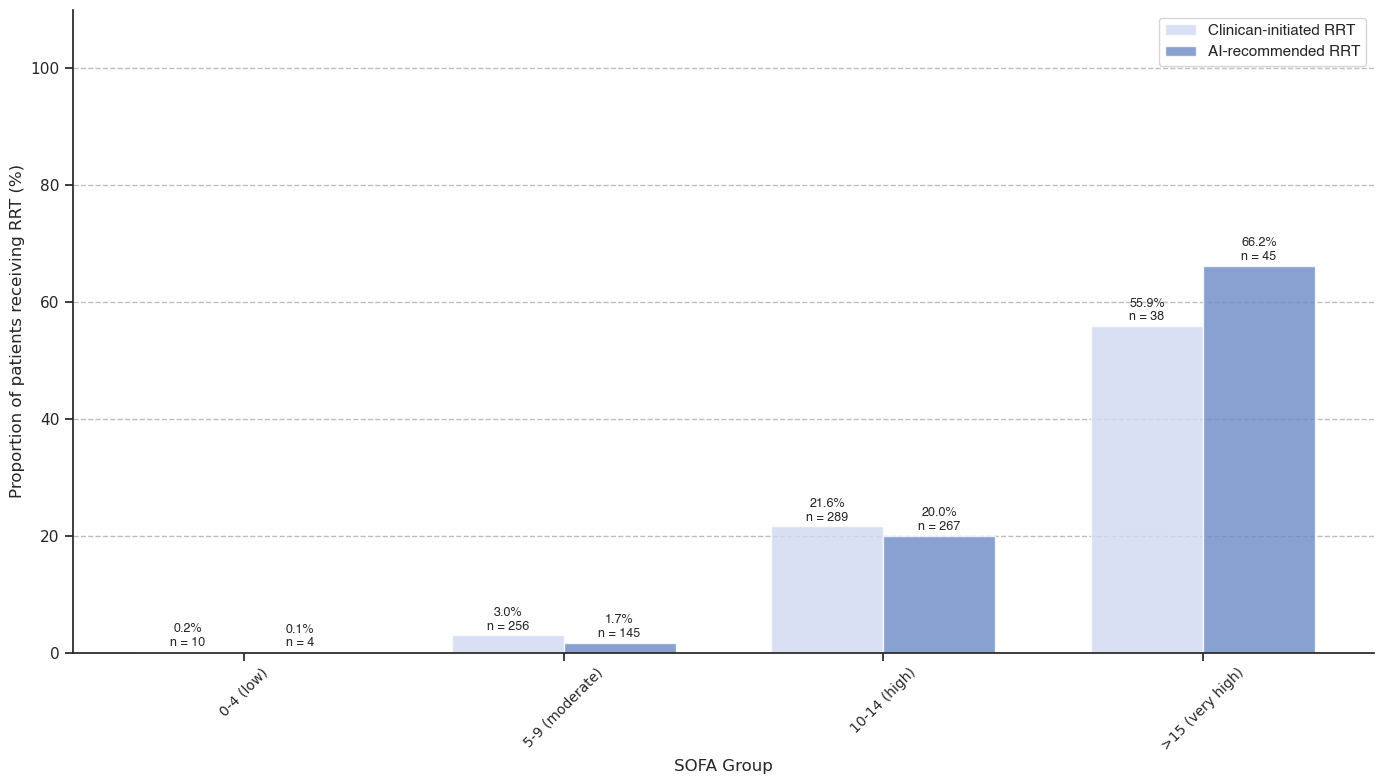

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os  # Make sure to import os if not already

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


sns.set(style="ticks", palette="pastel")
state_to_optimal_action = {state: action for state, action in enumerate(optimal_actions)}

RRT_THRESHOLD = 0.5

full_data_raw['ai_action'] = full_data_raw['state'].map(state_to_optimal_action)

if full_data_raw['ai_action'].isnull().any():
    missing_states = full_data_raw[full_data_raw['ai_action'].isnull()]['state'].unique()
    raise ValueError(f"Missing optimal actions for states: {missing_states}")

# Identify if RRT was ever performed by Clinicians and AI for each patient
patient_rrt = full_data_raw.groupby('icustayid').agg(
    clinician_rrt_occurred=('action', lambda x: (x >= RRT_THRESHOLD).any()),
    ai_rrt_occurred=('ai_action', lambda x: (x >= RRT_THRESHOLD).any()),
    max_SOFA=('SOFA', 'max')
).reset_index()

bins = [0, 4, 9, 14, 20]
labels = ['0-4 (low)', '5-9 (moderate)', '10-14 (high)', '>15 (very high)']
patient_rrt['SOFA_group'] = pd.cut(patient_rrt['max_SOFA'], bins=bins, labels=labels, include_lowest=True)

# Handle any SOFA scores outside the defined bins
if patient_rrt['SOFA_group'].isnull().any():
    print("Warning: Some patients have SOFA scores outside the defined bins. These will be excluded from grouping.")

    patient_rrt = patient_rrt.dropna(subset=['SOFA_group'])

action_distributions_sofa = patient_rrt.groupby('SOFA_group').agg(
    clinician_rrt_proportion=('clinician_rrt_occurred', 'mean'),
    ai_rrt_proportion=('ai_rrt_occurred', 'mean'),
    patient_count=('icustayid', 'count') 
).reset_index()

action_distributions_sofa['clinician_rrt_count'] = (action_distributions_sofa['clinician_rrt_proportion'] * action_distributions_sofa['patient_count']).round().astype(int)
action_distributions_sofa['ai_rrt_count'] = (action_distributions_sofa['ai_rrt_proportion'] * action_distributions_sofa['patient_count']).round().astype(int)

SOFA_groups = action_distributions_sofa['SOFA_group']
n_groups = len(SOFA_groups)
index = np.arange(n_groups)
bar_width = 0.35  
opacity = 0.8

fig, ax = plt.subplots(figsize=(14, 8))

plt.rcParams['font.family'] = 'Helvetica'

rects1 = ax.bar(index - bar_width/2, action_distributions_sofa['clinician_rrt_proportion']*100,
                bar_width, alpha=opacity, color='#d0d9f0', label='Clinican-initiated RRT')

rects2 = ax.bar(index + bar_width/2, action_distributions_sofa['ai_rrt_proportion']*100,
                bar_width, alpha=opacity, color='#6b8ac5', label='AI-recommended RRT')

ax.set_xlabel('SOFA Group', fontsize=12)
ax.set_ylabel('Proportion of patients receiving RRT (%)', fontsize=12)

ax.set_ylim(0, 110)


ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend()

def add_percentage_count_labels(bars, counts):
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{round(height,1)}%\nn = {count}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

add_percentage_count_labels(rects1, action_distributions_sofa['clinician_rrt_count'])
add_percentage_count_labels(rects2, action_distributions_sofa['ai_rrt_count'])

desired_ticks = 4

if n_groups > desired_ticks:
    tick_indices = [0, 1, n_groups - 1]
    tick_labels = [SOFA_groups[i] for i in tick_indices]
    ax.set_xticks(index[tick_indices])
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=10)
else:
    ax.set_xticks(index)
    ax.set_xticklabels(SOFA_groups, rotation=45, fontsize=10)

plt.tight_layout()

fig.savefig(os.path.join(fig_path, "mimic_SOFA_actions.png"), dpi=300)
fig.savefig(os.path.join(fig_path, "mimic_SOFA_actions.eps"))
plt.show()


/tmp/ipykernel_2860504/2018007261.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ICU_groups, rotation=45, fontsize=10)


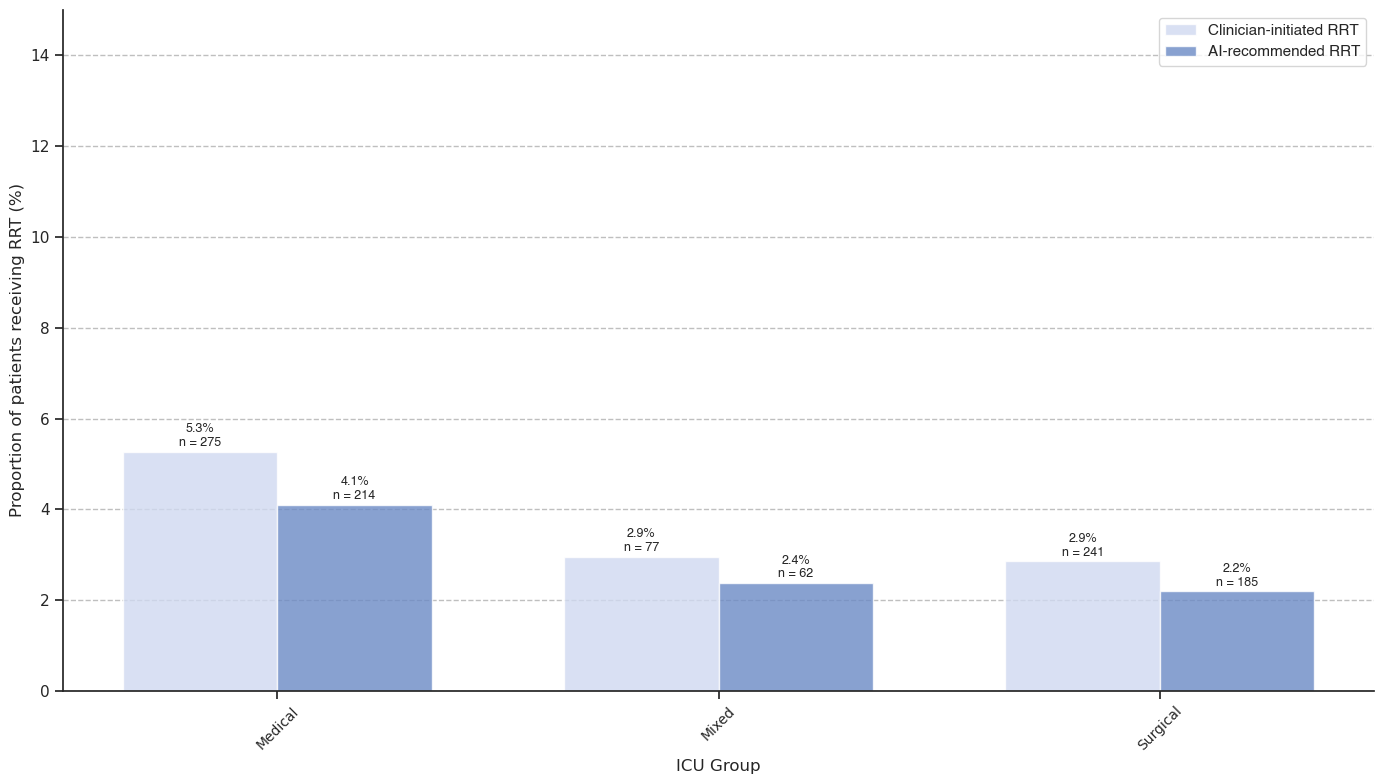

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_rrt_by_icu_group(full_data_raw, optimal_actions, icustays_csv_path):
    sns.set(style="ticks", palette="pastel")
    """
    Analyze and visualize RRT occurrences by ICU group for Clinician and AI actions.

    Parameters:
    - full_data_raw (pd.DataFrame): DataFrame containing ICU patient data with columns such as
                                     'icustayid', 'state', 'action', 'SOFA', etc.
    - optimal_actions (list or np.array): List/array where each index corresponds to a state,
                                          representing the AI's optimal action.
    - icustays_csv_path (str): File path to the 'icustays.csv' file.

    Returns:
    - None: Displays a bar plot comparing Clinician and AI-recommended RRT occurrences by ICU group.
    """

    state_to_optimal_action = {state: action for state, action in enumerate(optimal_actions)}
    try:
        icustays = pd.read_csv(icustays_csv_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"ICU stays data file not found at: {icustays_csv_path}")
    if 'first_careunit' not in( full_data_raw.columns):
        # Merge full_data_raw with icustays on 'icustayid' and 'stay_id'
        merged = full_data_raw.merge(
            icustays[['stay_id', 'first_careunit']],
            how='left',
            left_on='icustayid',
            right_on='stay_id'
        )
        
        
        # Assign the 'first_careunit' to full_data_raw
        full_data_raw['first_careunit'] = merged['first_careunit']
    

    careunit_to_group = {
        'Medical Intensive Care Unit (MICU)': 'Medical',
        'Coronary Care Unit (CCU)': 'Medical',
        'Neuro Intermediate': 'Surgical',
        'Medicine': 'Medical',
        'Med/Surg': 'Mixed',
        'Medicine/Cardiology Intermediate': 'Medical',
        'Neurology': 'Surgical',
        'Neuro Stepdown': 'Surgical',
        'Cardiac Vascular Intensive Care Unit (CVICU)': 'Surgical',
        'Surgical Intensive Care Unit (SICU)': 'Surgical',
        'Trauma SICU (TSICU)': 'Surgical',
        'Neuro Surgical Intensive Care Unit (Neuro SICU)': 'Surgical',
        'Surgery/Vascular/Intermediate': 'Mixed',
        'PACU': 'Surgical',
        'Intensive Care Unit (ICU)': 'Surgical',
        'Surgery/Trauma': 'Surgical',
        'Medical/Surgical Intensive Care Unit (MICU/SICU)': 'Mixed'
    }
    
    full_data_raw['ICU_group'] = full_data_raw['first_careunit'].map(careunit_to_group)
    
    # Handle any missing ICU groups
    if full_data_raw['ICU_group'].isnull().any():
        missing_careunits = full_data_raw[full_data_raw['ICU_group'].isnull()]['first_careunit'].unique()
        print(f"Warning: The following care units are not mapped to an ICU group and will be excluded: {missing_careunits}")
        # Exclude records with unmapped 'first_careunit'
        full_data_raw = full_data_raw.dropna(subset=['ICU_group'])

    full_data_raw['ai_action'] = full_data_raw['state'].map(state_to_optimal_action)
    

    if full_data_raw['ai_action'].isnull().any():
        missing_states = full_data_raw[full_data_raw['ai_action'].isnull()]['state'].unique()
        raise ValueError(f"Missing optimal actions for states: {missing_states}")
    
    # Identify if RRT was ever performed by Clinicians and AI for each patient
    patient_rrt = full_data_raw.groupby('icustayid').agg(
        clinician_rrt_occurred=('action', lambda x: (x == 1).any()),
        ai_rrt_occurred=('ai_action', lambda x: (x == 1).any()),
        ICU_group=('ICU_group', 'first')  # Assuming ICU_group is consistent per patient
    ).reset_index()
    
    action_distributions_icu = patient_rrt.groupby('ICU_group').agg(
        clinician_rrt_proportion=('clinician_rrt_occurred', 'mean'),
        ai_rrt_proportion=('ai_rrt_occurred', 'mean'),
        patient_count=('icustayid', 'count')  # Count of patients per ICU group
    ).reset_index()
    

    action_distributions_icu['clinician_rrt_count'] = (action_distributions_icu['clinician_rrt_proportion'] * action_distributions_icu['patient_count']).round().astype(int)
    action_distributions_icu['ai_rrt_count'] = (action_distributions_icu['ai_rrt_proportion'] * action_distributions_icu['patient_count']).round().astype(int)
    
    ICU_groups = action_distributions_icu['ICU_group']
    n_groups = len(ICU_groups)
    index = np.arange(n_groups)
    bar_width = 0.35  # Width of the bars
    opacity = 0.8

    fig, ax = plt.subplots(figsize=(14, 8))
    plt.rcParams['font.family'] = 'Helvetica'

    
    rects1 = ax.bar(index - bar_width/2, action_distributions_icu['clinician_rrt_proportion']*100,
                    bar_width, alpha=opacity, color='#d0d9f0', label='Clinician-initiated RRT')
    
    rects2 = ax.bar(index + bar_width/2, action_distributions_icu['ai_rrt_proportion']*100,
                    bar_width, alpha=opacity, color='#6b8ac5', label='AI-recommended RRT')
    
    ax.set_xlabel('ICU Group', fontsize=12)
    ax.set_ylabel('Proportion of patients receiving RRT (%)', fontsize=12)

    ax.set_xticklabels(ICU_groups, rotation=45, fontsize=10)
    ax.set_ylim(0, 15)  # Increased to accommodate patient counts

    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    desired_ticks = 3
    
    if n_groups > desired_ticks:
        tick_indices = [0, 1, n_groups - 1]
        tick_labels = [ICU_groups[i] for i in tick_indices]
        ax.set_xticks(index[tick_indices])
        ax.set_xticklabels(tick_labels, rotation=45, fontsize=10)
    else:

        ax.set_xticks(index)
        ax.set_xticklabels(ICU_groups, rotation=45, fontsize=10)
        

        ax.legend()
    
    def add_percentage_count_labels(bars, counts):
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax.annotate(f'{round(height,1)}%\nn = {count}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),  # 5 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=9)
    
    add_percentage_count_labels(rects1, action_distributions_icu['clinician_rrt_count'])
    add_percentage_count_labels(rects2, action_distributions_icu['ai_rrt_count'])
    
    plt.tight_layout()
    
    plt.show()
    fig.savefig(os.path.join(fig_path, "mimic_ICU_actions.png"), dpi=300)
    fig.savefig(os.path.join(fig_path, "mimic_ICU_actions.eps"))

    return action_distributions_icu


careunits = [
    'Medical Intensive Care Unit (MICU)', 'Coronary Care Unit (CCU)',
    'Neuro Intermediate', 'Medicine', 'Med/Surg', 'Medicine/Cardiology Intermediate',
    'Neurology', 'Neuro Stepdown', 'Cardiac Vascular Intensive Care Unit (CVICU)',
    'Surgical Intensive Care Unit (SICU)', 'Trauma SICU (TSICU)',
    'Neuro Surgical Intensive Care Unit (Neuro SICU)', 'Surgery/Vascular/Intermediate',
    'PACU', 'Intensive Care Unit (ICU)', 'Surgery/Trauma',
    'Medical/Surgical Intensive Care Unit (MICU/SICU)'
]

icu_stay_id_dir = main_path+'/data/icustays.csv'

action_distributions_icu =analyze_rrt_by_icu_group(full_data_raw, optimal_actions, icu_stay_id_dir)



In [22]:
action_counts = np.bincount(actions, minlength=2)

In [23]:
df = full_data_raw


action_at_least_1 = df[df['action'] >= 1].groupby('icustayid')['bloc'].max().reset_index()
action_at_least_1['group'] = 'at_least_1'

action_always_0 = df.groupby('icustayid').filter(lambda x: (x['action'] == 0).all())
action_always_0 = action_always_0.groupby('icustayid')['bloc'].max().reset_index()
action_always_0['group'] = 'always_0'

comparison_df = pd.concat([action_at_least_1, action_always_0])

pivot_df = comparison_df.pivot(index='icustayid', columns='group', values='bloc')


In [24]:
all_patients = full_data_raw.groupby('icustayid')['bloc'].max().reset_index()
all_patients['group'] = 'always_0'

Concordance Rate between clinician and AI bot: 97.08%


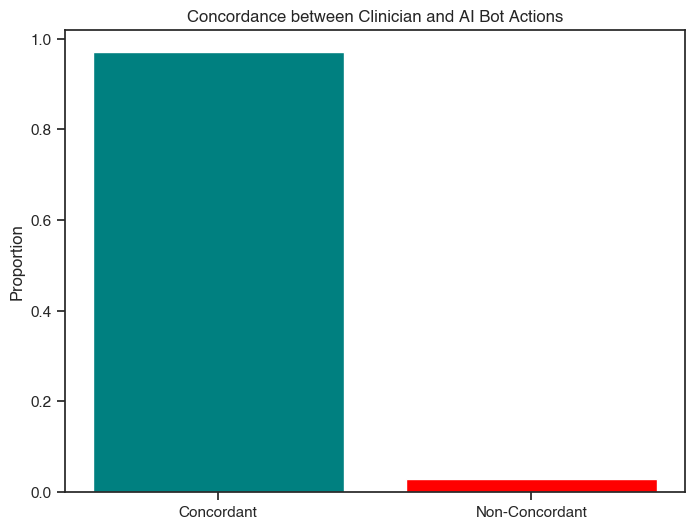

In [26]:
optimal_actions = model.Q.argmax(axis=1)

ai_recommended_actions = optimal_actions[states]

concordant = (actions == ai_recommended_actions).astype(int)

concordance_rate = np.mean(concordant)
print(f"Concordance Rate between clinician and AI bot: {concordance_rate:.2%}")

records['concordant'] = concordant

fig_concordance = plt.figure(figsize=(8, 6))
concordance_counts = np.bincount(concordant, minlength=2)
concordance_percentages = concordance_counts / len(concordant)

plot_concordance = concordance_percentages.copy()
plot_concordance[0] = concordance_percentages[1]
plot_concordance[1] = concordance_percentages[0]

plt.bar(['Concordant', 'Non-Concordant'], plot_concordance, color=['teal', 'red'])
plt.ylabel('Proportion')
plt.title('Concordance between Clinician and AI Bot Actions')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


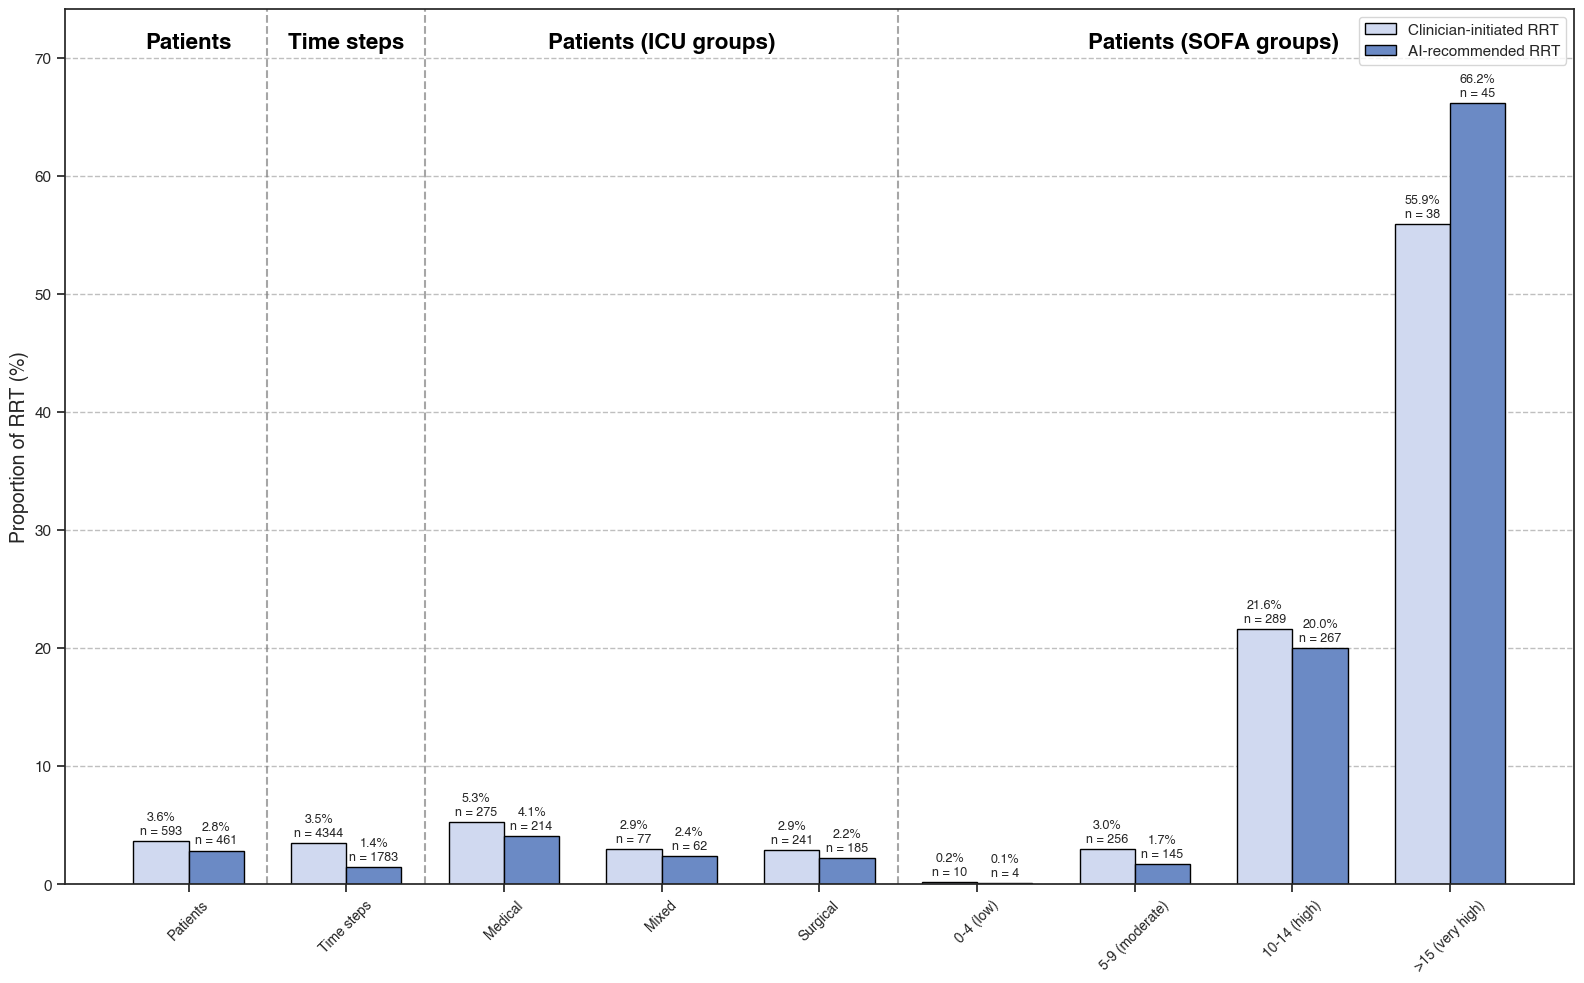

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="ticks", palette="pastel")
plt.rcParams['font.family'] = 'Helvetica'

time_steps_data = {
    'Category': ['Time steps'] * 2,
    'Method': ['Clinician-initiated RRT', 'AI-recommended RRT'],
    'Proportion': [clinician_time_steps_proportion, ai_time_steps_proportion],
    'Count': [clinician_time_steps_rrt, ai_time_steps_rrt]
}

patients_data = {
    'Category': ['Patients'] * 2,
    'Method': ['Clinician-initiated RRT', 'AI-recommended RRT'],
    'Proportion': [clinician_patient_proportion, ai_patient_proportion],
    'Count': [clinician_patient_rrt, ai_patient_rrt]
}

sofa_groups = action_distributions_sofa['SOFA_group'].tolist()
sofa_proportions_clinician = (action_distributions_sofa['clinician_rrt_proportion'] * 100).tolist()
sofa_proportions_ai = (action_distributions_sofa['ai_rrt_proportion'] * 100).tolist()
sofa_counts_clinician = action_distributions_sofa['clinician_rrt_count'].tolist()
sofa_counts_ai = action_distributions_sofa['ai_rrt_count'].tolist()

sofa_data = {
    'Category': sofa_groups * 2,
    'Method': ['Clinician-initiated RRT'] * len(sofa_groups) + ['AI-recommended RRT'] * len(sofa_groups),
    'Proportion': sofa_proportions_clinician + sofa_proportions_ai,
    'Count': sofa_counts_clinician + sofa_counts_ai
}

icu_groups = action_distributions_icu['ICU_group'].tolist()
icu_proportions_clinician = (action_distributions_icu['clinician_rrt_proportion'] * 100).tolist()
icu_proportions_ai = (action_distributions_icu['ai_rrt_proportion'] * 100).tolist()
icu_counts_clinician = action_distributions_icu['clinician_rrt_count'].tolist()
icu_counts_ai = action_distributions_icu['ai_rrt_count'].tolist()

icu_data = {
    'Category': icu_groups * 2,
    'Method': ['Clinician-initiated RRT'] * len(icu_groups) + ['AI-recommended RRT'] * len(icu_groups),
    'Proportion': icu_proportions_clinician + icu_proportions_ai,
    'Count': icu_counts_clinician + icu_counts_ai
}

combined_data = pd.concat([
    pd.DataFrame(time_steps_data),
    pd.DataFrame(patients_data),
    pd.DataFrame(icu_data),
    pd.DataFrame(sofa_data)
], ignore_index=True)

desired_order = ['Patients', 'Time steps'] + icu_groups + sofa_groups

combined_data['Category'] = pd.Categorical(combined_data['Category'], categories=desired_order, ordered=True)
combined_data = combined_data.sort_values('Category')

unique_categories = combined_data['Category'].cat.categories
unique_methods = combined_data['Method'].unique()

n_categories = len(unique_categories)
n_methods = len(unique_methods)

bar_width = 0.35
index = np.arange(n_categories)

fig, ax = plt.subplots(figsize=(16, 10))  # Adjust figsize as needed

colors = {
    'Clinician-initiated RRT': '#d0d9f0',
    'AI-recommended RRT': '#6b8ac5'
}

for i, method in enumerate(unique_methods):
    proportions = combined_data[combined_data['Method'] == method]['Proportion'].values
    counts = combined_data[combined_data['Method'] == method]['Count'].values
    
    bar_positions = index + (i - n_methods / 2) * bar_width + bar_width / 2
    
    bars = ax.bar(bar_positions, proportions, bar_width, label=method, color=colors.get(method, '#333333'),  edgecolor='black', linewidth=1 )
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{round(height,1)}%\nn = {count}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

ax.set_ylabel('Proportion of RRT (%)', fontsize=14)

ax.set_xticks(index)
ax.set_xticklabels(unique_categories, rotation=45, ha='center', fontsize=10)  # Reduced fontsize to 10

ax.legend()
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

y_max = combined_data['Proportion'].max() * 1.12 if combined_data['Proportion'].max() * 1.12 < 100 else 100
ax.set_ylim(0, y_max)


main_groups = {
    'Patients': ['Patients'],
    'Time steps': ['Time steps'],
    'Patients (ICU groups)': icu_groups,
    'Patients (SOFA groups)': sofa_groups
}

# Calculate the starting and ending indices for each main group
group_boundaries = {}
current_start = 0
for group, categories in main_groups.items():
    num_categories = len(categories)
    group_boundaries[group] = (current_start, current_start + num_categories - 1)
    current_start += num_categories


for group, (start, end) in group_boundaries.items():

    center = (start + end) / 2
    y_pos = y_max * 0.95  # 
    ax.text(center, y_pos, group, ha='center', va='bottom', fontsize=16, fontweight='bold', color='black')


plt.subplots_adjust(top=0.85)  




counts = [len(categories) for categories in main_groups.values()]
cumulative_counts = np.cumsum(counts)

separator_positions = cumulative_counts[:-1] - 0.5

# Add vertical dotted lines
for pos in separator_positions:
    ax.axvline(x=pos, linestyle='--', color='grey', alpha=0.7)


def wrap_label(label, width=15):
    if len(label) > width:
        return '\n'.join([label[i:i+width] for i in range(0, len(label), width)])
    else:
        return label


wrapped_labels = [wrap_label(label) for label in unique_categories]
ax.set_xticklabels(wrapped_labels, rotation=45, ha='center', fontsize=10)  # fontsize reduced to 10

plt.tight_layout()


fig.savefig(os.path.join(fig_path, "combined_mimic_actions.png"), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(fig_path, "combined_mimic_actions.eps"), bbox_inches='tight' )
plt.show()


Selected Example Patient ICU Stay ID: 32483321


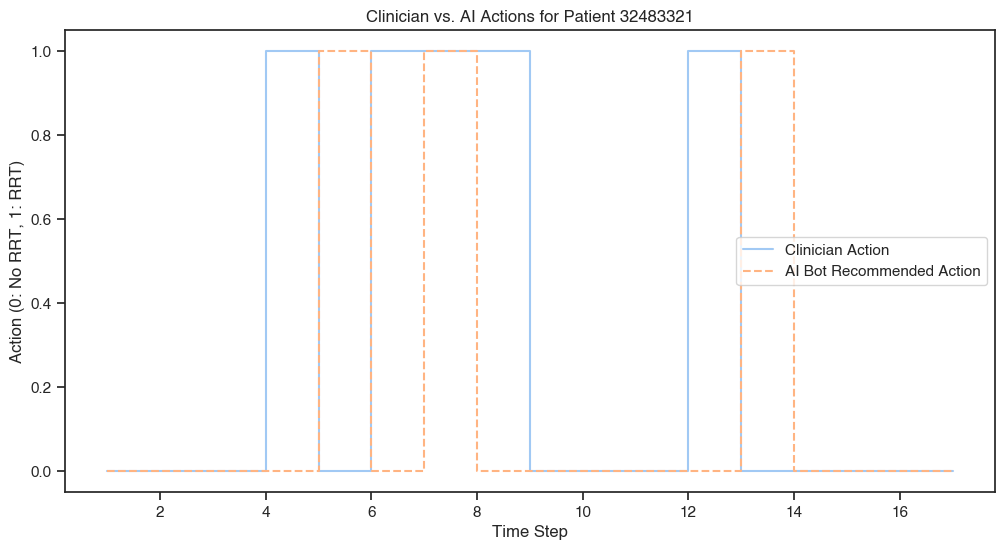

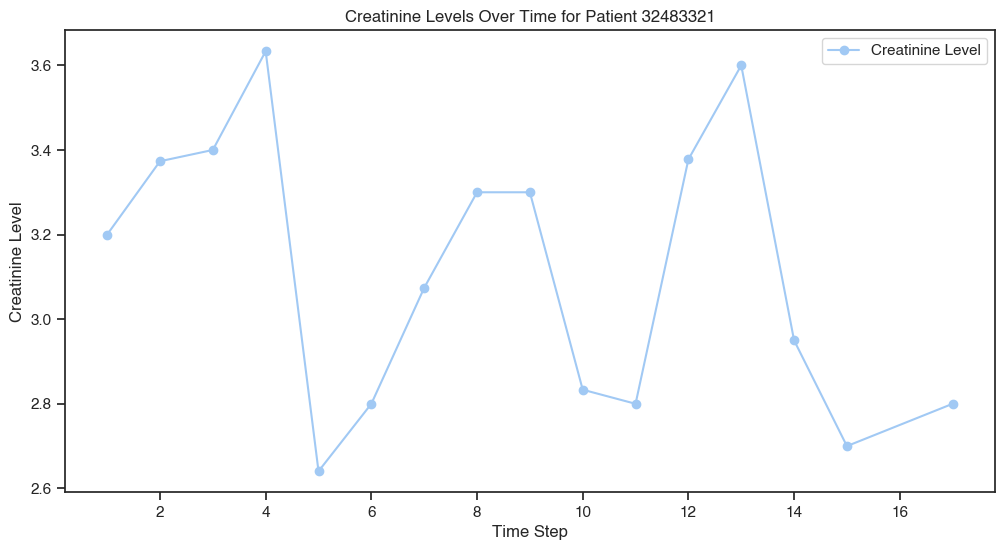

In [28]:
merged_df = full_data_raw

rrt_patients = merged_df.loc[merged_df['action'] == 1, C_ICUSTAYID].unique()

if len(rrt_patients) > 0:

    example_patient_id = np.random.choice(rrt_patients)
    print(f"Selected Example Patient ICU Stay ID: {example_patient_id}")

    patient_data = merged_df[merged_df[C_ICUSTAYID] == example_patient_id].copy()

    time_steps = patient_data[C_BLOC].values

    clinician_actions = patient_data['action'].values

    patient_indices = merged_df[C_ICUSTAYID] == example_patient_id
    patient_states = states[patient_indices]

    ai_actions = optimal_actions[patient_states]
    fig_patient = plt.figure(figsize=(12, 6))
    plt.step(time_steps, clinician_actions, label='Clinician Action', where='post')
    plt.step(time_steps, ai_actions, label='AI Bot Recommended Action', where='post', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Action (0: No RRT, 1: RRT)')
    plt.title(f'Clinician vs. AI Actions for Patient {example_patient_id}')
    plt.legend()
    plt.show()


    if 'Creatinine' in patient_data.columns:
        fig_creatinine = plt.figure(figsize=(12, 6))
        plt.plot(time_steps, patient_data['Creatinine'], label='Creatinine Level', marker='o')
        plt.xlabel('Time Step')
        plt.ylabel('Creatinine Level')
        plt.title(f'Creatinine Levels Over Time for Patient {example_patient_id}')
        plt.legend()
        plt.show()
else:
    print("No patients with RRT found in the dataset.")

Clinician-initiated RRT Mortality Rate: 39.76%
AI Bot RRT Mortality Rate: 45.63%
Chi-squared Test: chi2 = 18.5753, p-value = 0.0000


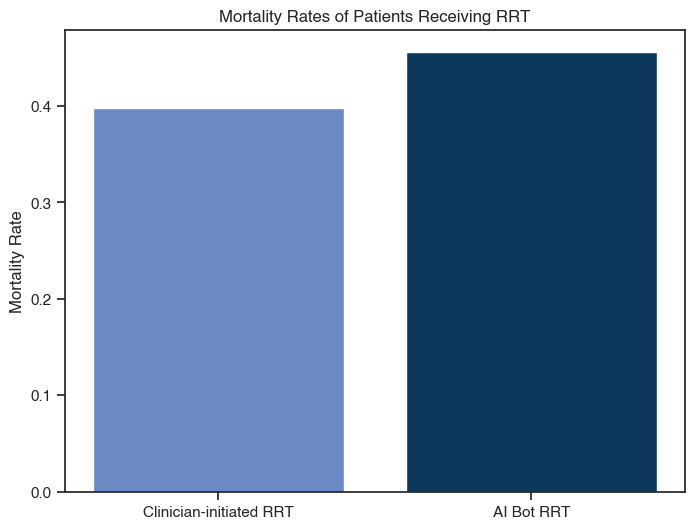

In [29]:
from scipy.stats import chi2_contingency

ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
clinician_rrt_indices = np.where(actions == 1)[0]
clinician_rrt_mortality = outcomes[clinician_rrt_indices]
clinician_rrt_mortality_rate = np.mean(clinician_rrt_mortality)
print(f"Clinician-initiated RRT Mortality Rate: {clinician_rrt_mortality_rate:.2%}")

ai_rrt_indices = np.where(ai_recommended_actions == 1)[0]
ai_rrt_mortality = outcomes[ai_rrt_indices]
ai_rrt_mortality_rate = np.mean(ai_rrt_mortality)
print(f"AI Bot RRT Mortality Rate: {ai_rrt_mortality_rate:.2%}")


clinician_rrt_deaths = np.sum(clinician_rrt_mortality)
clinician_rrt_survivors = len(clinician_rrt_mortality) - clinician_rrt_deaths
ai_rrt_deaths = np.sum(ai_rrt_mortality)
ai_rrt_survivors = len(ai_rrt_mortality) - ai_rrt_deaths

contingency_table = np.array([
    [clinician_rrt_deaths, clinician_rrt_survivors],
    [ai_rrt_deaths, ai_rrt_survivors]
])

chi2, p_value, _, _ = chi2_contingency(contingency_table)
print(f"Chi-squared Test: chi2 = {chi2:.4f}, p-value = {p_value:.4f}")

fig_mortality = plt.figure(figsize=(8, 6))
mortality_rates = [clinician_rrt_mortality_rate, ai_rrt_mortality_rate]
labels = ['Clinician-initiated RRT', 'AI Bot RRT']
plt.bar(labels, mortality_rates, color=['#6b8ac5', '#0c385c'])
plt.ylabel('Mortality Rate')
plt.title('Mortality Rates of Patients Receiving RRT')
plt.show()


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from sklearn.metrics import confusion_matrix

MIMICraw[metadata.columns] = metadata

optimal_actions = model.Q.argmax(axis=1)


patient_rrt = full_data_raw.groupby('icustayid').agg(
    clinician_rrt_occurred=('action', lambda x: (x == 1).any()),
    ai_rrt_occurred=('ai_action', lambda x: (x == 1).any()),
).reset_index()


confusion_data = patient_rrt.dropna(subset=['ai_rrt_occurred', 'clinician_rrt_occurred'])

cm = confusion_matrix(
    confusion_data['clinician_rrt_occurred'].astype(int), 
    confusion_data['ai_rrt_occurred'].astype(int), 
    labels=[1, 0]
)

cm_df = pd.DataFrame(
    cm, 
    index=['Clinician: RRT', 'Clinician: No RRT'], 
    columns=['AI: RRT', 'AI: No RRT']
)

print("Confusion Matrix:")
print(cm_df)


def get_group(row):
    if row['ai_rrt_occurred'] and row['clinician_rrt_occurred']:
        return 'Both RRT'
    elif row['ai_rrt_occurred'] and not row['clinician_rrt_occurred']:
        return 'AI-recommended RRT only'
    elif not row['ai_rrt_occurred'] and row['clinician_rrt_occurred']:
        return 'Clinician-initiated RRT only'
    else:
        return 'Neither RRT'
    
patient_rrt['group'] = patient_rrt.apply(get_group, axis=1)


max_bloc_per_patient = pd.Series(blocs).groupby(stay_ids).max().reset_index()
max_bloc_per_patient.columns = [C_ICUSTAYID, 'max_bloc']

global_max_bloc = max_bloc_per_patient['max_bloc'].max()
print(f"Global Maximum Bloc: {global_max_bloc}")

patient_events = {}
unique_patients = np.unique(stay_ids)
for icustay_id in unique_patients:
    event_indices = np.where(metadata[C_ICUSTAYID] == icustay_id)[0]
    if len(event_indices) > 0:
        event = outcomes[event_indices[0]]  #
        patient_events[icustay_id] = event
    else:
        patient_events[icustay_id] = np.nan 

survival_data = pd.DataFrame({
    C_ICUSTAYID: unique_patients,
    'event': [patient_events[id_] for id_ in unique_patients]
})

survival_data = survival_data.merge(max_bloc_per_patient, on=C_ICUSTAYID, how='left')

survival_data = survival_data.merge(patient_rrt[[C_ICUSTAYID, 'group']], left_on=C_ICUSTAYID, right_on='icustayid', how='left')

survival_data = survival_data.dropna(subset=['event', 'group'])


#    If event = 1 (death), use the patient's max_bloc; else, assign a censoring time (e.g., 180 blocs)
survival_data['survival_time'] = np.where(
    survival_data['event'] == 1,
    survival_data['max_bloc'],
    180
)
# Convert survival_time from blocs to days (assuming 1 bloc = 0.5 days; adjust if necessary)
survival_data['time_days'] = survival_data['survival_time'] * 0.5


patient_severity = full_data_raw.groupby(C_ICUSTAYID).agg({
    'age': 'first',  
    'SOFA': 'first'  
}).reset_index()

survival_data = survival_data.merge(patient_severity, on=C_ICUSTAYID, how='left')
survival_data = survival_data.dropna(subset=['age', 'SOFA'])

group_order = ['AI-recommended RRT only', 'Both RRT', 'Clinician-initiated RRT only', 'Neither RRT']
survival_data['group'] = pd.Categorical(survival_data['group'], categories=group_order, ordered=True)

print("Survival data head:")
print(survival_data.head())


Confusion Matrix:
                   AI: RRT  AI: No RRT
Clinician: RRT         422         171
Clinician: No RRT       39       15651
Global Maximum Bloc: 23
Survival data head:
   icustayid  event  max_bloc        group  survival_time  time_days  age  \
0   30000831      0         7  Neither RRT            180       90.0   78   
1   30001471      0         8  Neither RRT            180       90.0   91   
2   30002012      1         2  Neither RRT              2        1.0   61   
3   30002415      0         3  Neither RRT            180       90.0   72   
4   30003087      0        13  Neither RRT            180       90.0   55   

   SOFA  
0     8  
1     4  
2    10  
3     6  
4     2  


/tmp/ipykernel_2860504/2116362215.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_sizes = survival_data.groupby('group').size()
/tmp/ipykernel_2860504/2116362215.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_counts = survival_data.groupby('group')['event'].sum()


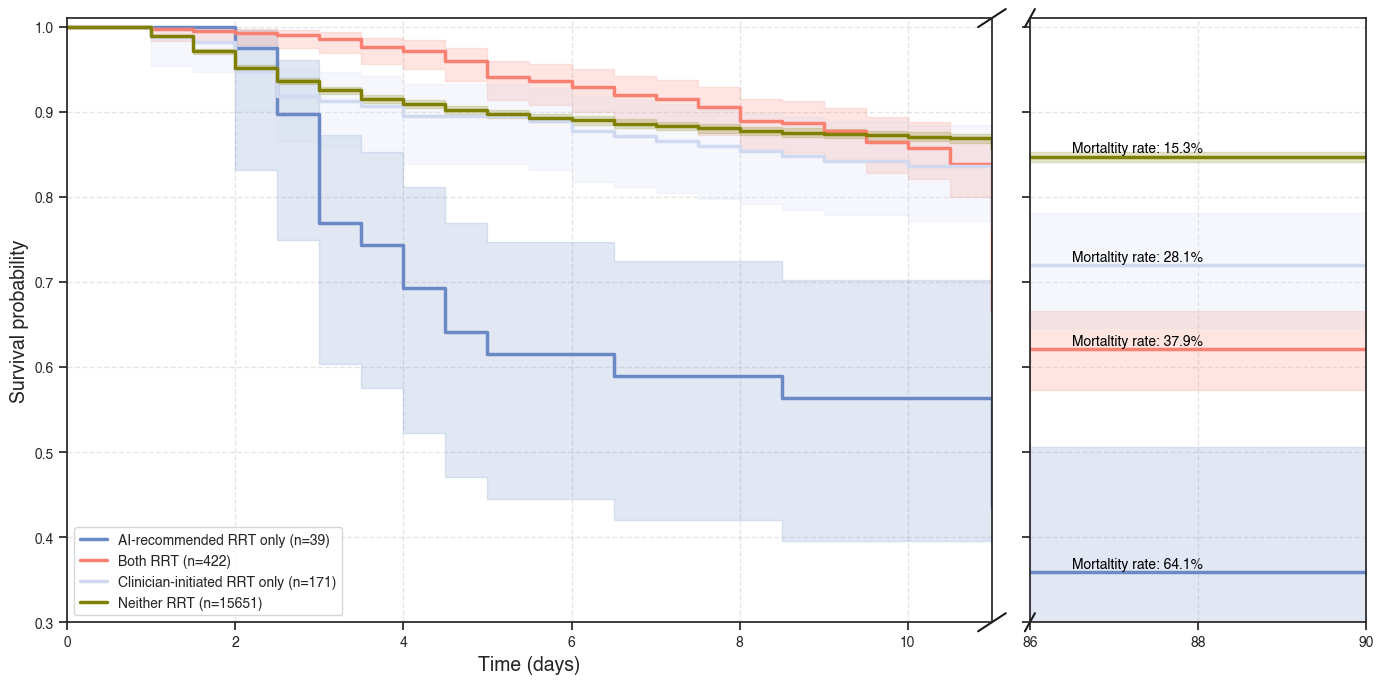

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [32]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from matplotlib.ticker import MultipleLocator

metadata.drop_duplicates(subset=['icustayid'])['outcome'].mean()
color_mapping = {
    'Neither RRT': 'olive',
    'AI-recommended RRT only': '#6b8ac5',
    'Both RRT': 'salmon',
    'Clinician-initiated RRT only': '#d0d9f0'
}

CI_mapping = {
    'Neither RRT': True,
    'AI-recommended RRT only': True,
    'Both RRT': True,
    'Clinician-initiated RRT only': True
}


group_sizes = survival_data.groupby('group').size()
event_counts = survival_data.groupby('group')['event'].sum()
mortality_rates = (event_counts / group_sizes) * 100  # Percentage


sns.set(style="ticks")
plt.rcParams['font.family'] = 'Helvetica'


left_days = 11  
right_days = 4 

fig, (ax1, ax2) = plt.subplots(
    1, 2, 
    sharey=True, 
    figsize=(14, 7),
    gridspec_kw={'width_ratios': [left_days, right_days]}
)


plt.subplots_adjust(wspace=0.05)

kmf_list = []
line_styles = ['-', '-', '-', '-']

for idx, group in enumerate(group_order):
    ix = survival_data['group'] == group
    kmf = KaplanMeierFitter()
    kmf.fit(
        durations=survival_data.loc[ix, 'time_days'],
        event_observed=survival_data.loc[ix, 'event'],
        label=group
    )
    
    color = color_mapping.get(group, 'gray')
    linestyle = line_styles[idx % len(line_styles)]
    ci = CI_mapping.get(group, True)
    

    kmf.plot_survival_function(
        ax=ax1,
        ci_show=ci,
        color=color,
        alpha=1,
        ci_alpha=0.2,
        linewidth=2.5,
        linestyle=linestyle
    )
    

    kmf.plot_survival_function(
        ax=ax2,
        ci_show=ci,
        color=color,
        alpha=1,
        ci_alpha=0.2,
        linewidth=2.5,
        linestyle=linestyle
    )
    
    kmf_list.append(kmf)
    
    max_day_right = ax2.get_xlim()[1]
    survival_at_max = kmf.survival_function_at_times(max_day_right).values[0]
    mortality_rate = mortality_rates[group]
    


    y_position = survival_at_max + 0.01 if survival_at_max + 0.01 < 1 else survival_at_max - 0.01
    ax2.text(
        max_day_right - 8,  # Slightly to the right of the plot
        y_position,
        f"Mortaltity rate: {mortality_rate:.1f}%",
        color='black',
        fontsize=10,
        verticalalignment='center',
        horizontalalignment='left'
    )

ax1.set_xlim(0, 11)
ax1.set_xlabel('Time (days)', fontsize=14)
ax1.set_ylabel('Survival probability', fontsize=14)
ax1.set_ylim([0.30, 1.01])


ax2.set_xlim(86, 90)
ax2.set_xlabel('', fontsize=14)
ax2.set_ylim([0.30, 1.01])

d = .015  
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

legend_labels = [f"{group} (n={group_sizes[group]})" for group in group_order]
handles, _ = ax1.get_legend_handles_labels()
ax1.legend(handles, legend_labels,fontsize=10, title_fontsize=12)

ax2.legend().set_visible(False)
for ax in [ax1, ax2]:
    ax.grid(
        which='major', 
        linestyle='--', 
        color='grey', 
        alpha=0.2,  # More visible grid
        linewidth=1
    )
    ax.xaxis.set_major_locator(MultipleLocator(2))  # Tick every 2 days
    ax.tick_params(axis='both', which='major', labelsize=10)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# Save the plot in specified formats
os.makedirs(fig_path, exist_ok=True)
fig.savefig(
    os.path.join(fig_path, "mimic_survival_plot_km_custom_equal_days.png"), 
    dpi=300
)
fig.savefig(
    os.path.join(fig_path, "mimic_survival_plot_km_custom_equal_days.eps")
)

# Close the Figure to Free Memory
plt.close(fig)


Confusion Matrix:
                   AI: RRT  AI: No RRT
Clinician: RRT         422         171
Clinician: No RRT       39       15651


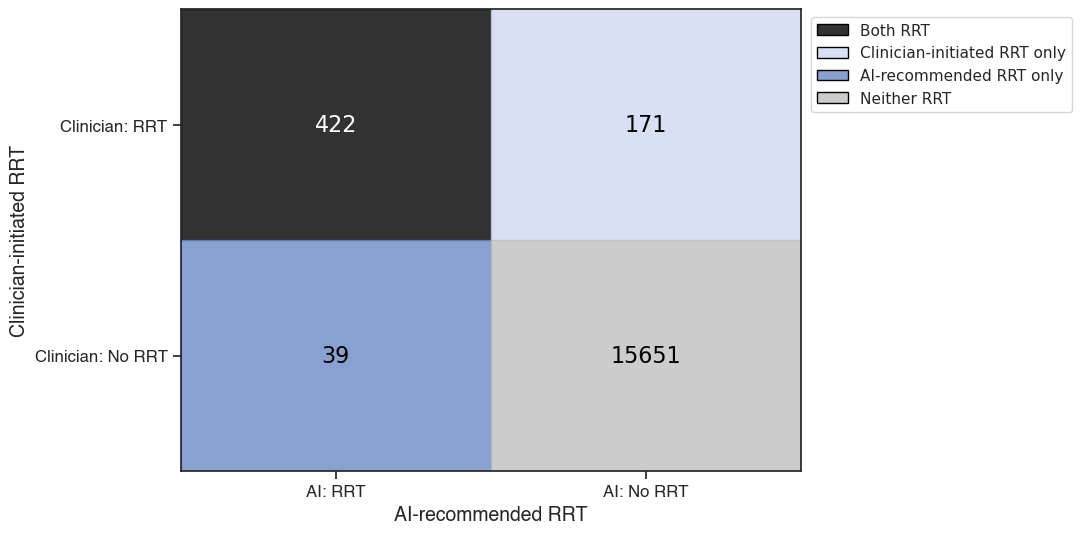

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Accuracy: 0.99
Precision: 0.92
Recall (Sensitivity): 0.71
F1 Score: 0.80


<Figure size 640x480 with 0 Axes>

In [33]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.patches import Patch


patient_rrt = full_data_raw.groupby('icustayid').agg(
    clinician_rrt_occurred=('action', lambda x: (x == 1).any()),
    ai_rrt_occurred=('ai_action', lambda x: (x == 1).any()),
).reset_index()

# Remove any potential NaN values after mapping
confusion_data = patient_rrt.dropna(subset=['ai_rrt_occurred', 'clinician_rrt_occurred'])

cm = confusion_matrix(
    confusion_data['clinician_rrt_occurred'], 
    confusion_data['ai_rrt_occurred'], 
    labels=[1, 0]
)
cm_df = pd.DataFrame(
    cm, 
    index=['Clinician: RRT', 'Clinician: No RRT'], 
    columns=['AI: RRT', 'AI: No RRT']
)

print("Confusion Matrix:")
print(cm_df)

desired_alpha = 0.8

def hex_to_rgba(hex_color, alpha=1.0):
    hex_color = hex_color.strip('#')
    r = int(hex_color[0:2], 16) / 255.0
    g = int(hex_color[2:4], 16) / 255.0
    b = int(hex_color[4:6], 16) / 255.0
    return (r, g, b, alpha)

hex_colors = {
    'Neither RRT': 'C0C0C0',           # silver
    'AI-recommended RRT only': '6b8ac5',
    'Both RRT': '000000',         # black
    'Clinician-initiated RRT only': 'd0d9f0'
}

rgba_colors = {
    'Neither RRT': hex_to_rgba(hex_colors['Neither RRT'], desired_alpha),
    'AI-recommended RRT only': hex_to_rgba(hex_colors['AI-recommended RRT only'], desired_alpha),
    'Both RRT': hex_to_rgba(hex_colors['Both RRT'], desired_alpha),
    'Clinician-initiated RRT only': hex_to_rgba(hex_colors['Clinician-initiated RRT only'], desired_alpha)
}

color_mapping = {
    ('Clinician: RRT', 'AI: RRT'): rgba_colors['Both RRT'],               # Both RRT
    ('Clinician: RRT', 'AI: No RRT'): rgba_colors['Clinician-initiated RRT only'],  # Clinician-initiated RRT only
    ('Clinician: No RRT', 'AI: RRT'): rgba_colors['AI-recommended RRT only'],         # AI-recommended RRT only
    ('Clinician: No RRT', 'AI: No RRT'): rgba_colors['Neither RRT']            # No RRT
}

cell_colors = []
for row in cm_df.index:
    row_colors = []
    for col in cm_df.columns:
        color = color_mapping.get((row, col), (1, 1, 1, 1))
        row_colors.append(color)
    cell_colors.append(row_colors)

cell_colors = np.array(cell_colors)

fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams['font.family'] = 'Helvetica'
sns.set(style="ticks", palette="pastel")
ax.yaxis.grid(False)
ax.xaxis.grid(False)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        cell_color = cell_colors[i, j]
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=cell_color))

        # Determine text color based on brightness
        r, g, b, a = cell_color
        brightness = (0.299*r + 0.587*g + 0.114*b)
        text_color = 'white' if brightness < 0.5 else 'black'

        ax.text(
            j + 0.5, i + 0.5, int(cm_df.iloc[i, j]),
            ha='center', va='center', color=text_color, fontsize=16
        )

ax.set_xlim(0, cm_df.shape[1])
ax.set_ylim(cm_df.shape[0], 0)
ax.set_xticks(np.arange(cm_df.shape[1]) + 0.5)
ax.set_yticks(np.arange(cm_df.shape[0]) + 0.5)
ax.set_xticklabels(cm_df.columns, fontsize=12)
ax.set_yticklabels(cm_df.index, fontsize=12)
plt.xlabel('AI-recommended RRT', fontsize=14)
plt.ylabel('Clinician-initiated RRT', fontsize=14)


legend_elements = [
    Patch(facecolor=rgba_colors['Both RRT'],             edgecolor='black', label='Both RRT'),
    Patch(facecolor=rgba_colors['Clinician-initiated RRT only'],   edgecolor='black', label='Clinician-initiated RRT only'),
    Patch(facecolor=rgba_colors['AI-recommended RRT only'],          edgecolor='black', label='AI-recommended RRT only'),
    Patch(facecolor=rgba_colors['Neither RRT'],               edgecolor='black', label='Neither RRT')
]

ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.45, 1))

plt.show()
plt.tight_layout()

fig.savefig(
    os.path.join(fig_path, "mimic_confusion_matrix.png"),
    dpi=300,
    bbox_inches='tight'  
)

fig.savefig(
    os.path.join(fig_path, "mimic_confusion_matrix.eps"),
    bbox_inches='tight'  
)

plt.close(fig)

y_true = confusion_data['clinician_rrt_occurred']
y_pred = confusion_data['ai_rrt_occurred']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [34]:
clinician_rrt_ai_no_rrt = confusion_data[
    (confusion_data['clinician_rrt_occurred'] == True) &
    (confusion_data['ai_rrt_occurred'] == False)
]['icustayid']

clinician_rrt_ai_no_rrt.to_csv(
    os.path.join(data_dir, "mimic_clinician_rrt_ai_no_rrt.csv"),
    index=False
)
print(f"Saved {len(clinician_rrt_ai_no_rrt)} icustayids to 'clinician_rrt_ai_no_rrt.csv'.")

clinician_no_rrt_ai_rrt = confusion_data[
    (confusion_data['clinician_rrt_occurred'] == False) &
    (confusion_data['ai_rrt_occurred'] == True)
]['icustayid']

clinician_no_rrt_ai_rrt.to_csv(
    os.path.join(data_dir, "mimic_clclinician_no_rrt_ai_rrt.csv"),
    index=False
)

print(f"Saved {len(clinician_no_rrt_ai_rrt)} icustayids to 'clinician_no_rrt_ai_rrt.csv'.")

clinician_no_rrt_no_ai_rrt = confusion_data[
    (confusion_data['clinician_rrt_occurred'] == False) &
    (confusion_data['ai_rrt_occurred'] == False)
]['icustayid']


clinician_no_rrt_no_ai_rrt.to_csv(
    os.path.join(data_dir, "mimic_clclinician_no_rrt_ai_no_rrt.csv"),
    index=False
)

print(f"Saved {len(clinician_no_rrt_no_ai_rrt)} icustayids to 'clinician_no_rrt_no_ai_rrt.csv'.")

clinician_rrt_ai_rrt = confusion_data[
    (confusion_data['clinician_rrt_occurred'] == True) &
    (confusion_data['ai_rrt_occurred'] == True)
]['icustayid']


clinician_rrt_ai_rrt.to_csv(
    os.path.join(data_dir, "mimic_clclinician_rrt_ai_rrt.csv"),
    index=False
)

print(f"Saved {len(clinician_rrt_ai_rrt)} icustayids to 'clinician_rrt_ai_rrt.csv'.")

Saved 171 icustayids to 'clinician_rrt_ai_no_rrt.csv'.
Saved 39 icustayids to 'clinician_no_rrt_ai_rrt.csv'.
Saved 15651 icustayids to 'clinician_no_rrt_no_ai_rrt.csv'.
Saved 422 icustayids to 'clinician_rrt_ai_rrt.csv'.


/tmp/ipykernel_2860504/835254752.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y=variable, data=df_plot, palette=palette, inner='quartile')


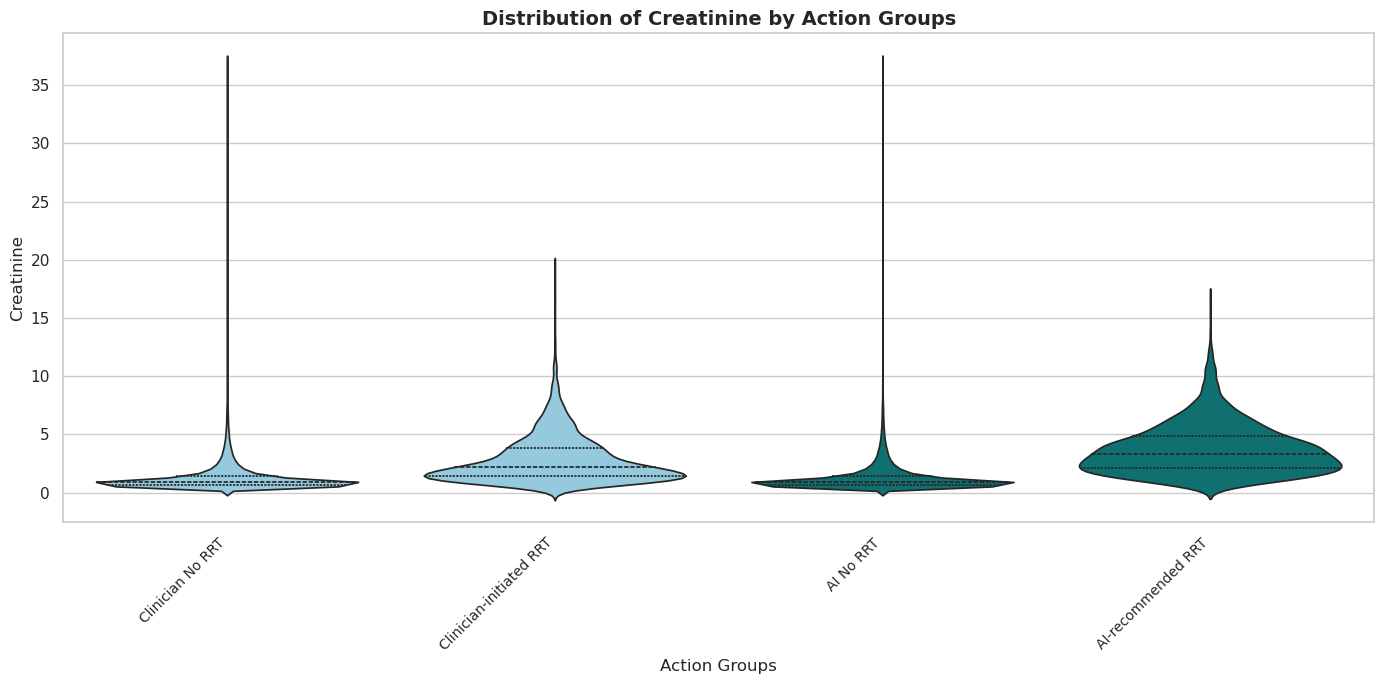

/tmp/ipykernel_2860504/835254752.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y=variable, data=df_plot, palette=palette, inner='quartile')


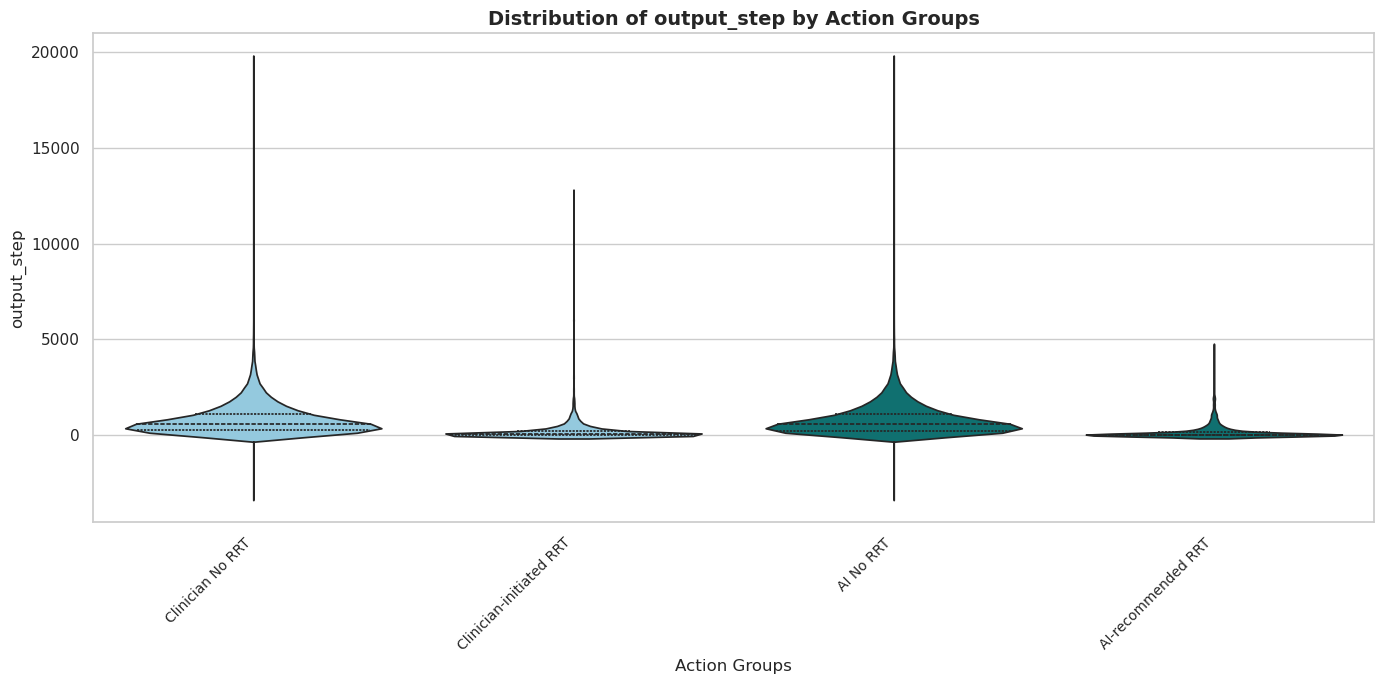

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn aesthetics are set
sns.set(style="whitegrid", palette="pastel")

def plot_violin(data, labels, variable, title, palette, figsize=(12, 6)):
    """
    Plots a violin plot for the given data.

    Parameters:
    - data: List of pandas Series.
    - labels: List of group labels.
    - variable: The variable name (string) to plot.
    - title: The title of the plot.
    - palette: Dictionary mapping group labels to colors.
    - figsize: Tuple for figure size.
    """
    # Combine data into a single DataFrame
    df_plot = pd.DataFrame({
        variable: np.concatenate(data),
        'Group': np.repeat(labels, [len(d) for d in data])
    })

    plt.figure(figsize=figsize)

    sns.violinplot(x='Group', y=variable, data=df_plot, palette=palette, inner='quartile')

    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.ylabel(variable, fontsize=12)
    plt.xlabel('Action Groups', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

variables_to_plot = ['Creatinine', 'output_step']

# Define the color palette
custom_palette = {
    'Clinician No RRT': 'skyblue',
    'Clinician-initiated RRT': 'skyblue',
    'AI No RRT': 'teal',
    'AI-recommended RRT': 'teal'
}

for variable in variables_to_plot:
    if variable in MIMICraw.columns:
        clinician_no_rrt = MIMICraw.loc[actions == 0, variable].dropna()
        clinician_rrt = MIMICraw.loc[actions == 1, variable].dropna()
        ai_no_rrt = MIMICraw.loc[ai_recommended_actions == 0, variable].dropna()
        ai_rrt = MIMICraw.loc[ai_recommended_actions == 1, variable].dropna()
        
        data = [clinician_no_rrt, clinician_rrt, ai_no_rrt, ai_rrt]
        labels = ['Clinician No RRT', 'Clinician-initiated RRT', 'AI No RRT', 'AI-recommended RRT']
        
        plot_title = f'Distribution of {variable} by Action Groups'

        plot_violin(
            data=data,
            labels=labels,
            variable=variable,
            title=plot_title,
            palette=custom_palette,
            figsize=(14, 7)
        )
    else:
        print(f"Variable '{variable}' not found in MIMICraw.")


In [37]:
# Clinician's actions
clinician_action_matrix = np.zeros((n_cluster_states, n_actions))
for state in range(n_cluster_states):
    state_actions = actions[states == state]
    action_counts = np.bincount(state_actions, minlength=n_actions)
    clinician_action_matrix[state, :] = action_counts / action_counts.sum() if action_counts.sum() > 0 else 0

# AI bot's recommended actions
ai_action_matrix = np.zeros((n_cluster_states, n_actions))
for state in range(n_cluster_states):
    state_ai_actions = ai_recommended_actions[states == state]
    action_counts = np.bincount(state_ai_actions, minlength=n_actions)
    ai_action_matrix[state, :] = action_counts / action_counts.sum() if action_counts.sum() > 0 else 0



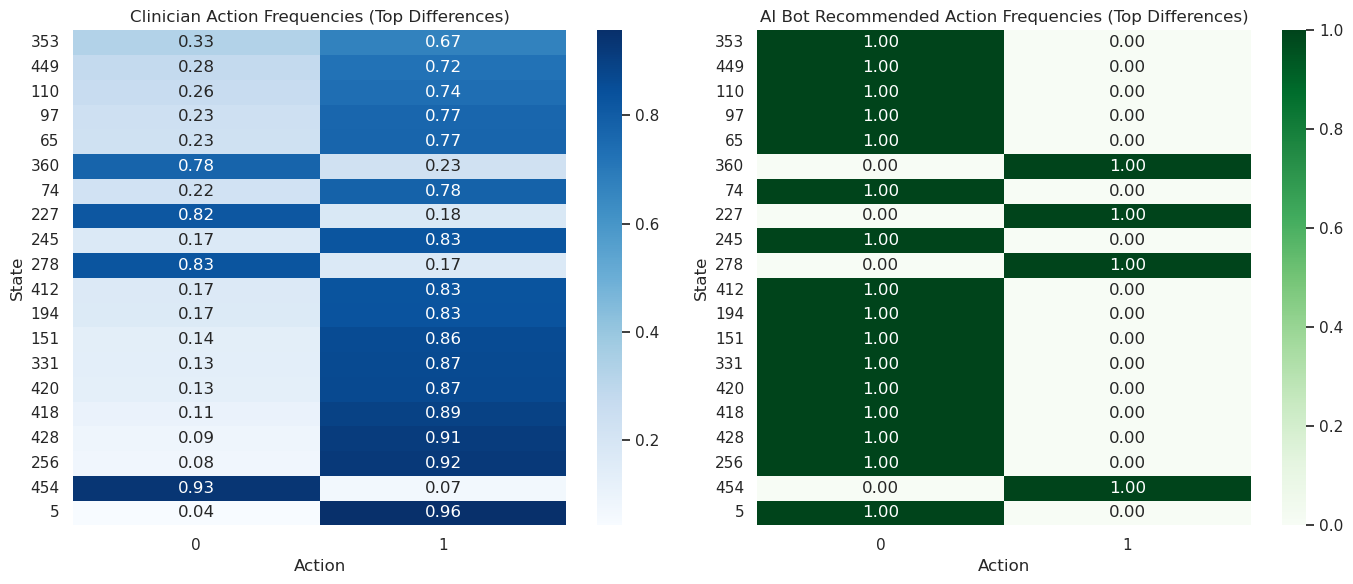

In [38]:
action_diff = np.abs(clinician_action_matrix - ai_action_matrix).sum(axis=1)

top_n = 20  # Adjust as needed
top_states_indices = np.argsort(action_diff)[-top_n:]

top_clinician_actions = clinician_action_matrix[top_states_indices, :]
top_ai_actions = ai_action_matrix[top_states_indices, :]


fig_heatmaps = plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(top_clinician_actions, cmap='Blues', annot=True, fmt=".2f", yticklabels=top_states_indices)
plt.title('Clinician Action Frequencies (Top Differences)')
plt.xlabel('Action')
plt.ylabel('State')

plt.subplot(1, 2, 2)
sns.heatmap(top_ai_actions, cmap='Greens', annot=True, fmt=".2f", yticklabels=top_states_indices)
plt.title('AI Bot Recommended Action Frequencies (Top Differences)')
plt.xlabel('Action')
plt.ylabel('State')

plt.tight_layout()
plt.show()


In [39]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px

sample_size = 10000
N = len(MIMICzs)
if N > sample_size:
    sampled_indices = np.random.choice(MIMICzs.index, sample_size, replace=False)
    MIMICzs_sampled = MIMICzs.iloc[sampled_indices] if isinstance(MIMICzs, pd.DataFrame) else MIMICzs[sampled_indices]
    actions_sampled = actions.iloc[sampled_indices] if isinstance(actions, pd.Series) else np.array(actions)[sampled_indices]
    ai_actions_sampled = ai_recommended_actions.iloc[sampled_indices] if isinstance(ai_recommended_actions, pd.Series) else np.array(ai_recommended_actions)[sampled_indices]
else:
    MIMICzs_sampled = MIMICzs
    actions_sampled = actions
    ai_actions_sampled = ai_recommended_actions

actions_sampled = np.where(np.array(actions_sampled) == 1, 'RRT', 'No RRT')
ai_actions_sampled = np.where(np.array(ai_actions_sampled) == 1, 'RRT', 'No RRT')

actions_sampled = pd.Series([str(a).strip() for a in actions_sampled])
ai_actions_sampled = pd.Series([str(a).strip() for a in ai_actions_sampled])

# Print unique values to ensure they contain both 'RRT' and 'No RRT'
print("Unique clinician_action values:", actions_sampled.unique())
print("Unique ai_action values:", ai_actions_sampled.unique())

tsne = TSNE(n_components=3, random_state=42)
state_embeddings = tsne.fit_transform(
    MIMICzs_sampled.values if isinstance(MIMICzs_sampled, pd.DataFrame) else MIMICzs_sampled
)

embedding_df = pd.DataFrame({
    'x': state_embeddings[:, 0],
    'y': state_embeddings[:, 1],
    'z': state_embeddings[:, 2],
    'clinician_action': actions_sampled.values,
    'ai_action': ai_actions_sampled.values
})



# Create a combined category
def categorize(row):
    c_action = row['clinician_action']
    ai_action = row['ai_action']
    if c_action == 'No RRT' and ai_action == 'No RRT':
        return 'Neither RRT'
    elif c_action == 'No RRT' and ai_action == 'RRT':
        return 'AI-recommended RRT only'
    elif c_action == 'RRT' and ai_action == 'RRT':
        return 'Both RRT'
    elif c_action == 'RRT' and ai_action == 'No RRT':
        return 'Clinician-initiated RRT only'
    else:
        return 'No RRT'

embedding_df['combined_category'] = embedding_df.apply(categorize, axis=1)


print("Category counts:\n", embedding_df['combined_category'].value_counts())

color_mapping = {
    'Neither RRT': 'olive',           # silver
    'AI-recommended RRT only': '#6b8ac5',
    'Both RRT': 'salmon',         # black
    'Clinician-initiated RRT only': '#d0d9f0'
}

fig = px.scatter_3d(
    embedding_df,
    x='x', y='y', z='z',
    color='combined_category',
    color_discrete_map=color_mapping,
    hover_data=['clinician_action', 'ai_action'],
    title='3D t-SNE of Patient States - Single Interactive Plot (Color by Combined Category)'
)

fig.update_traces(marker=dict(size=5, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))
plt.rcParams['font.family'] = 'Helvetica'
# Increase figure size
fig.update_layout(
    width=1600,  # Width in pixels
    height=1000, # Height in pixels
    legend_title_text='Category'
)

fig.write_html(os.path.join(fig_path,"mimic_tsne_3d_interactive_colormap.html"))

fig.show()


Unique clinician_action values: ['No RRT' 'RRT']
Unique ai_action values: ['No RRT' 'RRT']
Category counts:
 combined_category
Neither RRT                     9587
Clinician-initiated RRT only     259
Both RRT                          93
AI-recommended RRT only           61
Name: count, dtype: int64


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


merged_data = full_data_raw.copy()


state_df = pd.DataFrame({
    'icustayid': stay_ids,
    'state': states
})


state_df = state_df.drop_duplicates(subset='icustayid')

merged_data = merged_data.merge(state_df, on='icustayid', how='left')

if len(ai_recommended_actions) != len(merged_data):
    raise ValueError(f"'ai_recommended_actions' length ({len(ai_recommended_actions)}) does not match 'merged_data' length ({len(merged_data)}).")
merged_data['ai_recommended_actions'] = ai_recommended_actions

merged_data['action_discrepancy'] = (merged_data['action'] != merged_data['ai_recommended_actions']).astype(int)


patient_features = reduced_features.copy()

if 'gender' in merged_data.columns:

    merged_data = pd.get_dummies(merged_data, columns=['gender'], drop_first=True)

    patient_features = [col for col in patient_features if col != 'gender'] + [col for col in merged_data.columns if col.startswith('gender_')]
else:
    print("No 'gender' column found in merged_data. Skipping gender encoding.")

y_discrepancy = merged_data['action_discrepancy']

X = merged_data[patient_features]

print("Missing values in each feature before handling missing data:")
print(X.isnull().sum())

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


def compute_feature_importance_rf(X, y, feature_names, n_estimators=200, random_state=42):
    """
    Fits a Random Forest model and returns feature importances.
    
    Parameters:
    - X: Features DataFrame
    - y: Target variable
    - feature_names: List of feature names
    - n_estimators: Number of trees in the forest
    - random_state: Seed for reproducibility
    
    Returns:
    - feature_importance: DataFrame with feature importances
    - model: Trained Random Forest model
    - scaler: Fitted StandardScaler
    - X_test_scaled: Scaled test features
    - y_test: Test target
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, class_weight='balanced')
    rf.fit(X_train_scaled, y_train)
    
    importances = rf.feature_importances_
    
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Sort features by importance
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)
    
    return feature_importance, rf, scaler, X_test_scaled, y_test

discrepancy_importance, rf_discrepancy, scaler_discrepancy, X_test_discrepancy, y_test_discrepancy = compute_feature_importance_rf(
    X_imputed, y_discrepancy, X.columns, n_estimators=200, random_state=42
)


print("\nFeature Importances from Random Forest Model (n_estimators=200):")
print(discrepancy_importance)

top_n_general = 10
top_general_features = discrepancy_importance.head(top_n_general)['feature'].tolist()


remaining_features = discrepancy_importance[~discrepancy_importance['feature'].isin(top_general_features)]

print("\n--- Training Random Forest for Clinician Alignment ---")
clinician_importance, rf_clinician, scaler_clinician, X_test_clinician, y_test_clinician = compute_feature_importance_rf(
    X_imputed, (y_discrepancy == 0).astype(int), X.columns, n_estimators=200, random_state=42
)

print("\n--- Training Random Forest for AI Alignment ---")
ai_importance, rf_ai, scaler_ai, X_test_ai, y_test_ai = compute_feature_importance_rf(
    X_imputed, (y_discrepancy == 1).astype(int), X.columns, n_estimators=200, random_state=42
)



No 'gender' column found in merged_data. Skipping gender encoding.
Missing values in each feature before handling missing data:
output_step              0
SOFA                     0
cumulated_balance        0
Creatinine               0
Platelets_count          0
Chloride                 0
BUN                      0
Anion_Gap                0
Calcium                  0
input_total              0
WBC_count                0
Total_bili               0
Phosphorous              0
O2flow                   0
output_total             0
Weight_kg            10350
RASS                     0
Sodium                   0
Temp_C                   0
age                      0
max_dose_vaso            0
PAWmean                  0
GCS                      0
SGOT                     0
PT                       0
PTT                      0
RBC_count                0
LDH                      0
Ht                       0
RR                       0
HCO3                     0
SpO2                     0
Ionised_

In [42]:
feature_name_mapping = {
    'output_step': '12-hour total output, mL',
    'SOFA': 'SOFA score',
    'cumulated_balance': 'Cumulative balance, mL',
    'Creatinine': 'Creatinine, mg/dL',
    'Platelets_count': 'Platelet count, ×10^3/µL',
    'Chloride': 'Chloride, mEq/L',
    'BUN': 'BUN, mg/dL',
    'Anion_Gap': 'Anion gap, mEq/L',
    'Calcium': 'Calcium, mg/dL',
    'input_total': 'Total input, mL',
    'WBC_count': 'WBC count, ×10^3/µL',
    'Total_bili': 'Total bilirubin, mg/dL',
    'Phosphorous': 'Phosphorus, mg/dL',
    'O2flow': 'O2 flow, L/min',
    'output_total': 'Total output, mL',
    'Weight_kg': 'Weight, kg',
    'RASS': 'RASS score',
    'Sodium': 'Sodium, mEq/L',
    'Temp_C': 'Temperature, °C',
    'age': 'Age, years',
    'max_dose_vaso': 'Maximum vasopressor dose, µg/kg/min',
    'PAWmean': 'Mean airway pressure, cmH2O',
    'GCS': 'GCS score',
    'SGOT': 'AST (SGOT), U/L',
    'PT': 'PT, s',
    'PTT': 'PTT, s',
    'RBC_count': 'RBC count, ×10^6/µL',
    'LDH': 'LDH, U/L',
    'Ht': 'Hematocrit, %',
    'RR': 'Respiratory rate, breaths/min',
    'HCO3': 'Bicarbonate, mEq/L',
    'SpO2': 'SpO2, %',
    'Ionised_Ca': 'Ionized calcium, mmol/L',
    'Hb': 'Hemoglobin, g/dL',
    'FiO2_1': 'FiO2, %',
    'SGPT': 'ALT (SGPT), U/L',
    'Shock_Index': 'Shock index',
    'Glucose': 'Glucose, mg/dL',
    'HR': 'Heart rate, beats/min',
    'MinuteVentil': 'Minute ventilation, L/min',
    'MeanBP': 'Mean blood pressure, mmHg',
    'INR': 'INR',
    'Potassium': 'Potassium, mEq/L',
    'Fibrinogen': 'Fibrinogen, mg/dL',
    'Arterial_pH': 'Arterial pH',
    'PaO2_FiO2': 'PaO2/FiO2 ratio',
    'TidalVolume': 'Tidal volume, mL',
    'paO2': 'PaO2, mmHg',
    'Albumin': 'Albumin, g/dL',
    'DiaBP': 'Diastolic blood pressure, mmHg',
    'input_step': '12-hour total input, mL',
    'Magnesium': 'Magnesium, mg/dL',
    'SysBP': 'Systolic blood pressure, mmHg',
    'PAWpeak': 'Peak airway pressure, cmH2O',
    'extubated': 'Extubated (yes/no)',
    'Arterial_BE': 'Arterial base excess, mEq/L',
    'PAWplateau': 'Plateau airway pressure, cmH2O',
    'Height_cm': 'Height, cm',
    'CVP': 'cCntral venous pressure, mmHg',
    'paCO2': 'PaCO2, mmHg',
    'Arterial_lactate': 'Arterial lactate, mmol/L',
    'PEEP': 'PEEP, cmH2O',
    'CK_MB': 'CK-MB, ng/mL',
    'ETCO2': 'End-tidal CO2, mmHg',
    'Troponin': 'Troponin, ng/mL',
    'mechvent': 'Mechanical ventilation (yes/no)',
    'Absolute_Neutrophil_Count': 'Absolute neutrophil count, ×10^3/µL',
    'SIRS': 'SIRS criteria',
    'SaO2': 'SaO2, %',
    'Triglyceride': 'Triglycerides, mg/dL',
    'SvO2': 'SvO2, %',
    'PAPsys': 'Pulmonary artery systolic pressure, mmHg',
    'PAPdia': 'Pulmonary artery diastolic pressure, mmHg',
    're_admission': 're-admission (yes/no)',
    'PAPmean': 'Mean pulmonary artery pressure, mmHg',
    'Creatinine_Urine': 'Urine creatinine, mg/dL',
    'gender': 'gender (M/F)',
    'BNP': 'BNP, pg/mL',
    'CRP': 'CRP, mg/L',
    'Urea_Nitrogen_Urine': 'Urine urea nitrogen, mg/dL',
    'Sodium_Urine': 'Urine sodium, mEq/L',
    'Potassium_Urine': 'Urine potassium, mEq/L',
    'Iron': 'Iron, µg/dL',
    'Ammonia': 'Ammonia, µg/dL',
    'Thyroid_Stimulating_Hormone': 'TSH, mIU/L',
    'Total_protein': 'Total protein, g/dL',
    'CI': 'Cardiac index, L/min/m²',
    'ACT': 'ACT, s',
    'T3': 'T3, ng/dL',
    'Gamma_Glutamyltransferase': 'GGT, U/L',
    'Heparin_LMW': 'Low molecular weight heparin (yes/no)',
    'APACHEII_Renal_Failure': 'APACHE II renal failure score',
    'Osmolality_Urine': 'Urine osmolality, mOsm/kg'
}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


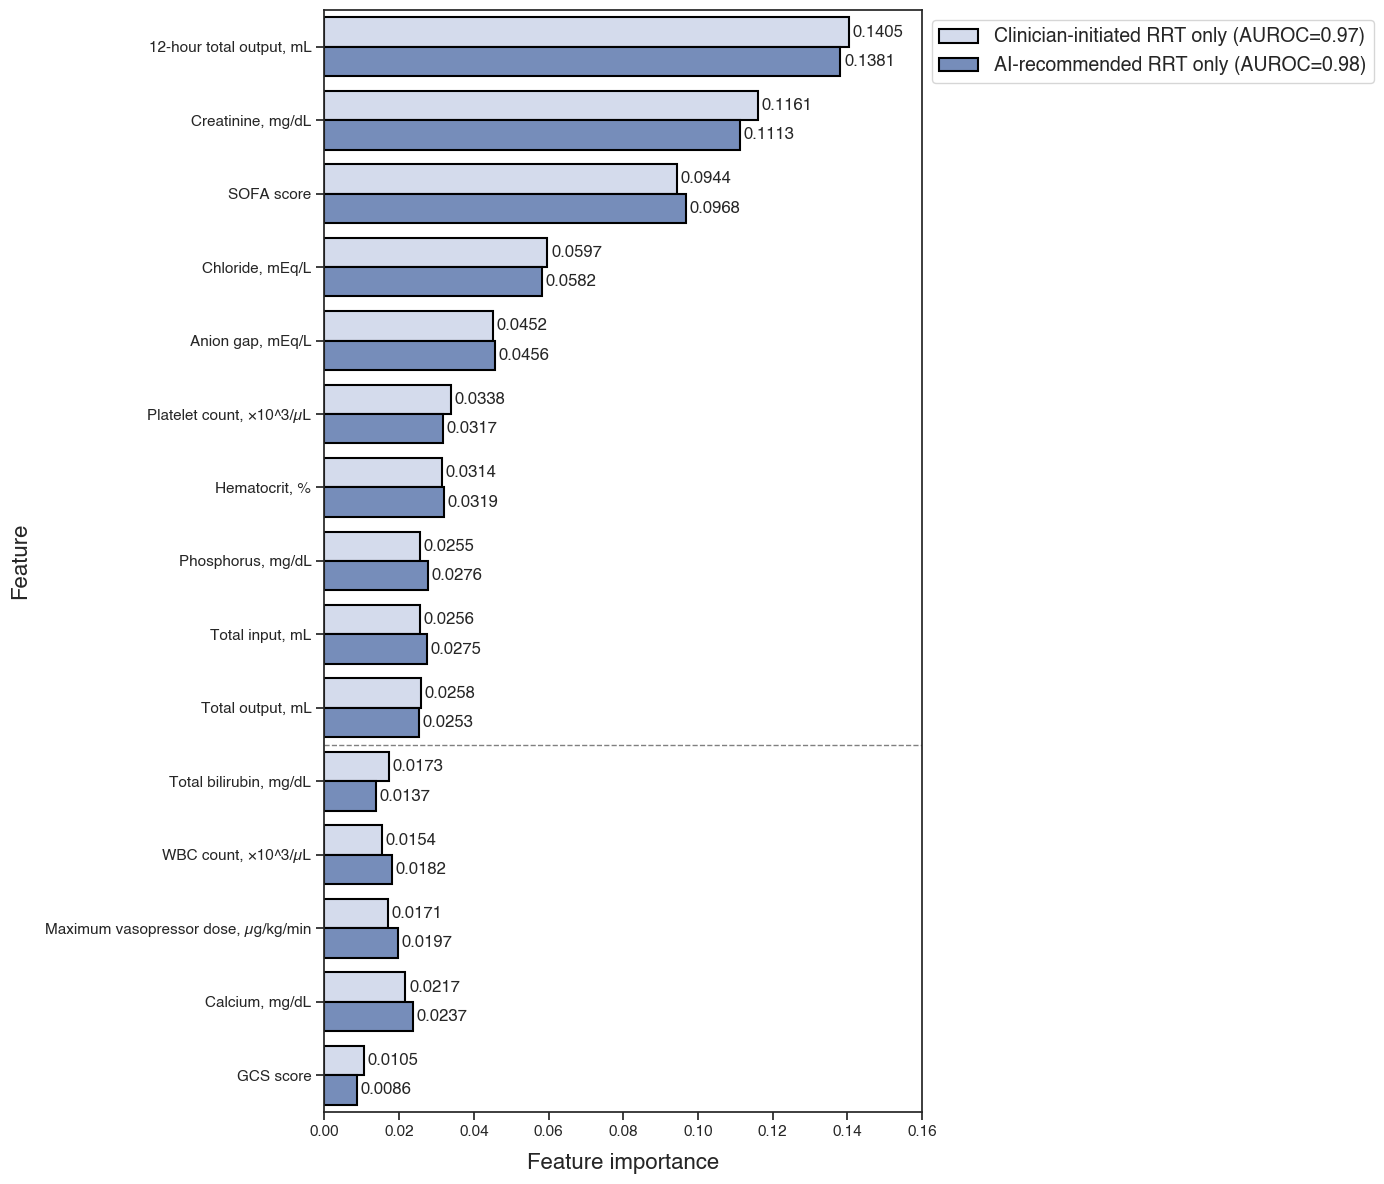

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score


clinician_importance.rename(columns={'importance': 'importance_clinician'}, inplace=True)
ai_importance.rename(columns={'importance': 'importance_ai'}, inplace=True)


importance_df = clinician_importance.merge(ai_importance, on='feature')


importance_df['average_importance'] = (
    importance_df['importance_clinician'] + importance_df['importance_ai']
) / 2


importance_df['disparity'] = (
    importance_df['importance_ai'] - importance_df['importance_clinician']
).abs()


importance_df_sorted = importance_df.sort_values(by='average_importance', ascending=False)

top_n_average = 10
top_average_features = importance_df_sorted.head(top_n_average)['feature'].tolist()

top_disparity_features = (
    importance_df_sorted[~importance_df_sorted['feature'].isin(top_average_features)]
    .sort_values(by='disparity', ascending=False)
    .head(5)['feature']
    .tolist()
)


features_to_plot = top_average_features + top_disparity_features


plot_data = importance_df[importance_df['feature'].isin(features_to_plot)].copy()
plot_data['feature_display'] = plot_data['feature'].map(feature_name_mapping)

missing_mappings = plot_data['feature_display'].isnull()
if missing_mappings.any():
    print("Warning: The following features are missing mappings and will use original names:")
    print(plot_data.loc[missing_mappings, 'feature'])
    plot_data['feature_display'].fillna(plot_data['feature'], inplace=True)

plot_data['feature_display'] = pd.Categorical(
    plot_data['feature_display'],
    categories=[feature_name_mapping.get(f, f) for f in features_to_plot],
    ordered=True
)

plot_melted = plot_data.melt(
    id_vars=['feature_display'],
    value_vars=['importance_clinician', 'importance_ai'],
    var_name='Source',
    value_name='Importance'
)


y_proba_clinician = rf_clinician.predict_proba(X_test_clinician)[:, 1]
auc_clinician = roc_auc_score(y_test_clinician, y_proba_clinician)
y_proba_ai = rf_ai.predict_proba(X_test_ai)[:, 1]
auc_ai = roc_auc_score(y_test_ai, y_proba_ai)

plot_melted['Source'] = plot_melted['Source'].map({
    'importance_clinician': f'Clinician-initiated RRT only (AUROC={auc_clinician:.2f})',
    'importance_ai': f'AI-recommended RRT only (AUROC={auc_ai:.2f})'
})

palette = {
    f'Clinician-initiated RRT only (AUROC={auc_clinician:.2f})': '#d0d9f0',
    f'AI-recommended RRT only (AUROC={auc_ai:.2f})': '#6b8ac5'
}

sns.set(style="ticks")

plt.figure(figsize=(14, 12)) 
plt.rcParams['font.family'] = 'Helvetica'

# Create a horizontal bar plot
ax = sns.barplot(
    data=plot_melted,
    x='Importance',
    y='feature_display',  
    hue='Source',
    palette=palette,
    errorbar=None,  
    edgecolor='black',
    linewidth=1.5
)

plt.xlabel('Feature importance', fontsize=16, labelpad=10)
plt.ylabel('Feature', fontsize=16, labelpad=10)

threshold = 0.001 
for p in ax.patches:
    width = p.get_width()
    if width >= threshold:
        y = p.get_y() + p.get_height() / 2
        ax.text(width + 0.001, y, f"{width:.4f}", va='center', fontsize=12)


plt.axhline(y=top_n_average - 0.5, color='grey', linestyle='--', linewidth=1)

plt.legend(
    title=None,
    fontsize=14,
    title_fontsize=16,
    loc='upper left',
    bbox_to_anchor=(1.00, 1)  
)


plt.xlim([0, 0.16])
plt.tight_layout()

plt.savefig(os.path.join(fig_path, 'mimic_feature_importance.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_path, 'mimic_feature_importance.eps'), dpi=300, bbox_inches='tight')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


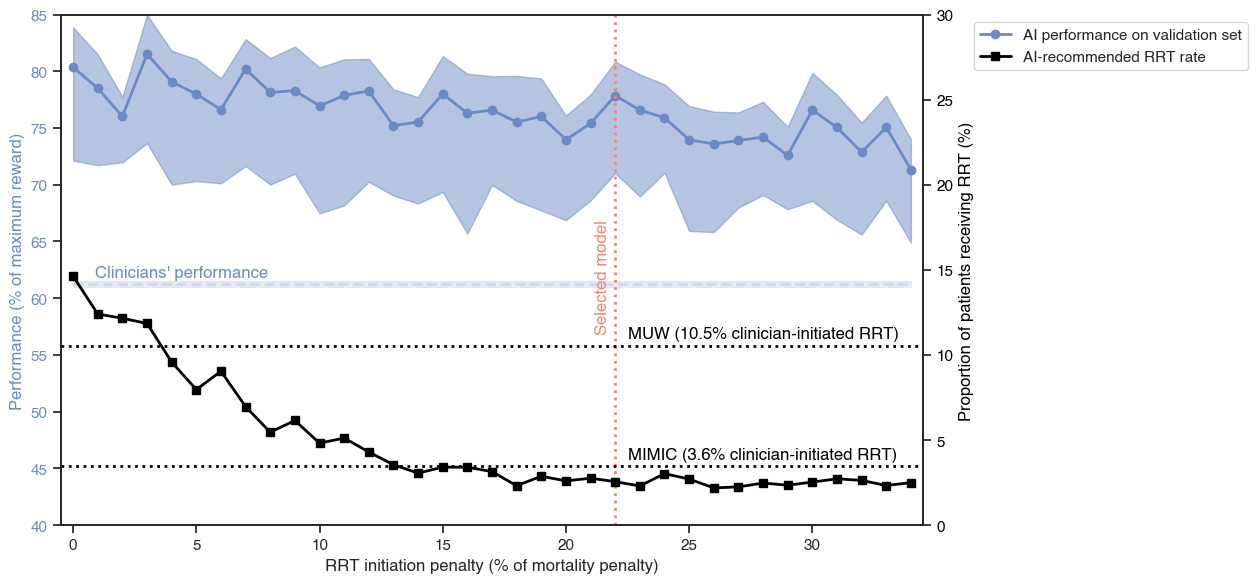

In [47]:
import os
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

C_ICUSTAYID = 'icustayid' 
data_dir = main_path+'/data/model'

penalties = []
treated_fractions = []


val_wis_01_raw = []
val_wis_05_raw = []
val_wis_means_raw = []
val_wis_95_raw = []
val_ql_95_raw = []
wis_indices = []

train_wis_01_raw = []
train_wis_05_raw = []
train_wis_means_raw = []
train_wis_95_raw = []

penalties = []
treated_fractions = []

val_wis_01_raw = []
val_wis_05_raw = []
val_wis_means_raw = []
val_wis_95_raw = []
val_ql_95_raw = []
wis_indices = []

train_wis_01_raw = []
train_wis_05_raw = []
train_wis_means_raw = []
train_wis_95_raw = []

for i in range(-0, 35, 1):
    penal_amount = i / 100.
    out_dir = os.path.join(data_dir, "models_penal", str(penal_amount))
    model_para_dir = os.path.join(out_dir, "model_params_40")    
    best_model_dir =  os.path.join(model_para_dir, "best") 
    model_stats_path = os.path.join(out_dir, "model_stats.csv")
    additional_vars_path = os.path.join(best_model_dir, "additional_vars_best.pkl")

    if not os.path.exists(model_stats_path) or not os.path.exists(additional_vars_path):
        print(f"Skipping penalty {penal_amount}, required files not found.")
        continue

    all_model_stats = pd.read_csv(model_stats_path)
    wis_index = all_model_stats['val_bootwis_0.05'].idxmax()
    top_5_models = all_model_stats.nlargest(25, 'val_bootwis_0.05')

    # Average validation metrics
    val_wis_05_avg = top_5_models['val_bootwis_0.05'].mean()
    val_wis_01_avg = top_5_models['val_bootwis_0.01'].mean()
    val_wis_mean_avg = top_5_models['val_bootwis_mean'].mean()
    val_wis_95_avg = top_5_models['val_bootwis_0.95'].mean()

    # Average training metrics
    train_wis_05_avg = top_5_models['train_bootwis_0.05'].mean()
    train_wis_mean_avg = top_5_models['train_bootwis_mean'].mean()
    train_wis_95_avg = top_5_models['train_bootwis_0.95'].mean()

    # Average QL metric
    ql_95_avg = top_5_models['train_bootql_0.95'].mean()

    # Append averaged metrics
    val_wis_means_raw.append(val_wis_mean_avg)
    val_wis_01_raw.append(val_wis_01_avg)
    val_wis_05_raw.append(val_wis_05_avg)
    val_wis_95_raw.append(val_wis_95_avg)
    val_ql_95_raw.append(ql_95_avg)

    train_wis_means_raw.append(train_wis_mean_avg)
    train_wis_05_raw.append(train_wis_05_avg)
    train_wis_95_raw.append(train_wis_95_avg)

    treated_fractions_per_model = []
    
    top5_dir = os.path.join(model_para_dir, 'top5')
    
    for idx in range(5):  
        top_vars_path = os.path.join(top5_dir, f'additional_vars_top5_{idx}.pkl')
        
        if not os.path.exists(top_vars_path):
            print(f"Missing top5 vars file for model {idx} at penalty {penal_amount}")
            continue
    
        with open(top_vars_path, 'rb') as f:
            top_vars = pickle.load(f)
    
        prob_treatment = top_vars['model_probs']  # Shape (n_samples,)

        df_val_temp = top_vars['metadata_val'].copy()
        df_val_temp['prob_treatment'] = prob_treatment[:, 1]
        max_prob_per_patient = df_val_temp.groupby(C_ICUSTAYID)['prob_treatment'].max()
        n_treated = (max_prob_per_patient > 0.5).sum()
        treated_fraction = (n_treated / max_prob_per_patient.shape[0]) * 100 
        
        treated_fractions_per_model.append(treated_fraction)
    
    if len(treated_fractions_per_model) > 0:
        treated_fraction_avg = np.mean(treated_fractions_per_model)
    else:
        treated_fraction_avg = 0  # Handle missing files case
    
    treated_fractions.append(treated_fraction_avg)
    penalties.append(penal_amount * 100)
    
    wis_indices.append(wis_index)

all_wis_95 = np.array(val_wis_95_raw)  

max_wis_95_over_all = 100

val_wis_means = np.array(val_wis_means_raw) / max_wis_95_over_all * 100
val_wis_01 = np.array(val_wis_01_raw) / max_wis_95_over_all * 100
val_wis_05 = np.array(val_wis_05_raw) / max_wis_95_over_all * 100
val_wis_95 = np.array(val_wis_95_raw) / max_wis_95_over_all * 100
val_ql_95 = np.array(val_ql_95_raw) / max_wis_95_over_all * 100

train_wis_means = np.array(train_wis_means_raw) / max_wis_95_over_all * 100
train_wis_05 = np.array(train_wis_05_raw) / max_wis_95_over_all * 100
train_wis_95 = np.array(train_wis_95_raw) / max_wis_95_over_all * 100

avg_wis_means = (val_wis_means + train_wis_means) / 2.
avg_wis_05 = (val_wis_05 + train_wis_05) / 2.
avg_wis_95 = (val_wis_95 + train_wis_95) / 2.


fig, ax1 = plt.subplots(figsize=(10, 6))
sns.set(style="ticks")
plt.rcParams['font.family'] = 'Helvetica'

color1 = '#6b8ac5'
ax1.set_xlabel('RRT initiation penalty (% of mortality penalty)')
ax1.set_ylabel('Performance (% of maximum reward)', color=color1)
ax1.plot(penalties, val_wis_means, marker='o', color=color1, label='AI performance on validation set', linewidth=2)
ax1.fill_between(penalties, val_wis_05, val_wis_95, color=color1, alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color1)

x_pos_text = -0.1  

clinician_mean = np.mean(val_ql_95)
clinician_std = np.std(val_ql_95)
ax1.plot(penalties, [clinician_mean for _ in val_ql_95], color='#d0d9f0', linestyle='--', linewidth=2)
ax1.fill_between(penalties, clinician_mean + clinician_std, clinician_mean - clinician_std, color='#d0d9f0', alpha=0.5)
ax1.text(x_pos_text+1, clinician_mean + clinician_std + 0.1, "Clinicians' performance", color=color1, va='bottom')

ax2 = ax1.twinx()
color2 = 'black'
ax2.set_ylabel('Proportion of patients receiving RRT (%)', color=color2)
ax2.plot(penalties, treated_fractions, marker='s', color=color2, label='AI-recommended RRT rate', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

mimic_line = 3.5   
muw_line = 10.5     
ax2.axhline(y=mimic_line, color='black', linestyle=':', linewidth=2)
ax2.axhline(y=muw_line, color='black', linestyle=':', linewidth=2)
ax1.set_ylim([40, 85])
ax2.set_ylim([0, 30])

ax2.text( 22.5, mimic_line+ 0.2, "MIMIC (3.6% clinician-initiated RRT)", color='black', va='bottom')
ax2.text( 22.5 , muw_line+ 0.3, "MUW (10.5% clinician-initiated RRT)", color='black', va='bottom')

selected_penalty = 22 #Mark 22% penality model
if selected_penalty in penalties:
    
    ax1.axvline(x=selected_penalty, color='salmon', linestyle=':', linewidth=2) 
    
    ax1.text(selected_penalty - 0.8, ax1.get_ylim()[1] - 18, 'Selected model', color='salmon', rotation=90, 
             verticalalignment='top', horizontalalignment='left')
else:
    print(f"Selected penalty {selected_penalty}% not found in penalties list.")

# ============================

fig.tight_layout()
plt.grid(False)

plt.xlim([-0.5, 34.5])
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))  
ax1.yaxis.grid(False)
ax1.xaxis.grid(False)

fig.savefig(os.path.join(fig_path, 'mimic_penalties.png'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(fig_path, 'mimic_penalties.eps'),  format='eps', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
pen_data = pd.DataFrame(np.array(penalties)/100., columns=['penalties'] )
pen_data['wis_indices'] = np.array(wis_indices)
pen_data['treated_fractions'] = np.array(treated_fractions)
pen_data['val_wis_01'] = np.array(val_wis_01)
pen_data['val_wis_05'] = np.array(val_wis_05)
pen_data['val_wis_mean'] = np.array(val_wis_means)
pen_data['val_wis_95'] = np.array(val_wis_95)


pen_data['train_wis_05'] = np.array(train_wis_05)
pen_data['avg_wis_05'] = np.array(avg_wis_05)


In [49]:
pen_data

penalties  wis_indices  treated_fractions  val_wis_01  val_wis_05  \
0        0.00           62          14.628241   69.629759   72.127704   
1        0.01          264          12.404264   68.926939   71.723185   
2        0.02          330          12.156863   68.646164   71.972944   
3        0.03          209          11.851559   61.920453   73.667325   
4        0.04          355           9.582840   68.140670   70.007137   
5        0.05          208           7.966838   68.168708   70.317904   
6        0.06          114           9.043295   67.397238   70.121305   
7        0.07          387           6.966706   64.970612   71.653843   
8        0.08          445           5.461245   65.335778   70.010873   
9        0.09          256           6.150809   62.113083   70.966892   
10       0.10          380           4.821687   66.421137   67.479810   
11       0.11          240           5.119095   65.750999   68.170264   
12       0.12          224           4.300566   66.452240   70.265408   
13       0.13          202           3.553099   65.492932   69.043225   
14       0.14           39           3.058297   64.259947   68.343863   
15       0.15          326           3.410975   58.771297   69.358424   
16       0.16          301           3.405711   63.830197   65.691088   
17       0.17          284           3.147783   66.014035   69.984614   
18       0.18          466           2.318726   62.660942   68.574843   
19       0.19          325           2.879326   57.591606   67.737504   
20       0.20           14           2.600342   64.009860   66.876522   
21       0.21           84           2.760890   64.585229   68.615259   
22       0.22          330           2.558231   61.087164   71.010369   
23       0.23           96           2.305567   63.452983   68.964050   
24       0.24           13           3.029346   63.103415   71.048606   
25       0.25          164           2.710883   58.276434   65.928925   
26       0.26          215           2.189762   63.535789   65.824904   
27       0.27          279           2.250296   61.396977   67.990282   
28       0.28           17           2.476642   50.565974   69.098377   
29       0.29          289           2.347677   64.694681   67.836104   
30       0.30          280           2.534544   55.888195   68.583605   
31       0.31          239           2.724043   62.373201   66.907656   
32       0.32          497           2.631925   63.862182   65.611295   
33       0.33           14           2.331886   60.318040   68.597532   
34       0.34          223           2.500329   63.471806   64.900434   

    val_wis_mean  val_wis_95  train_wis_05  avg_wis_05  
0      80.352651   83.881308    -10.949178   30.589263  
1      78.502408   81.480572      6.501128   39.112157  
2      76.021554   77.750281    -15.586948   28.192998  
3      81.515453   84.989208    -28.492249   22.587538  
4      79.073469   81.796056    -20.783296   24.611921  
5      77.981493   81.072241    -34.714930   17.801487  
6      76.621044   79.371703    -26.069549   22.025878  
7      80.182133   82.830451    -14.846664   28.403590  
8      78.138112   81.168066    -18.036449   25.987212  
9      78.289367   82.175936      3.909245   37.438069  
10     76.945642   80.340179     -4.849483   31.315163  
11     77.871051   81.056030     -5.297295   31.436485  
12     78.263232   81.080524    -15.947903   27.158752  
13     75.204976   78.403510      7.008517   38.025871  
14     75.535743   77.722142      9.580881   38.962372  
15     77.995724   81.342688      2.651759   36.005091  
16     76.300013   79.786028      8.445867   37.068478  
17     76.578200   79.553987    -26.379682   21.802466  
18     75.519028   79.589935      2.276810   35.425827  
19     76.019370   79.367879    -26.121793   20.807855  
20     73.968238   76.097389    -13.650990   26.612766  
21     75.396507   77.940019     -5.443402   31.585928  
22     77.856418   80.844153     19.676420   45.343395  
23     